In [1]:
import numpy as np
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from random import randint, shuffle
from collections import defaultdict

from torch_geometric.utils import from_networkx, to_networkx, remove_isolated_nodes, dropout_edge
from torch_geometric.loader import DataLoader
from torch_scatter import scatter_mean, scatter_std, scatter_min, scatter_max

from GOOD.utils.synthetic_data import synthetic_structsim
from GOOD.utils.args import args_parser, CommonArgs
from GOOD import config_summoner
from GOOD.kernel.main import initialize_model_dataset
from GOOD.kernel.pipeline_manager import load_pipeline
from GOOD.ood_algorithms.ood_manager import load_ood_alg
from GOOD.utils.initial import reset_random_seed
import GOOD.kernel.pipelines.xai_metric_utils as xai_utils
from GOOD.kernel.pipelines.basic_pipeline import CustomDataset

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2


In [2]:
def normalize_belonging(belonging):
        #TODO: make more efficient
        ret = []
        i = -1
        for j , elem in enumerate(belonging):
            if len(ret) > 0 and elem == belonging[j-1]:
                ret.append(i)
            else:
                i += 1
                ret.append(i)
        return torch.tensor(ret, dtype=int)

def plot_base(p):
    plt.figure(figsize=(2,2))
    nx.draw(p)
    plt.show()

house, _ = synthetic_structsim.house(start=0)
crane, _ = synthetic_structsim.crane(start=0)
dircycle, _ = synthetic_structsim.dircycle(start=0)
path, _ = synthetic_structsim.path(start=0, width=11)
# plot_base(crane)

## Load models and dataset

In [3]:
DATASET = "TopoFeature/basis"
SEED = 1
DEVICE = "cuda:0"
MODEL = "GSAT"

In [4]:
args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
args.average_edge_attn = "mean"
args.use_norm = "none"
config_path = f"./final_configs/{DATASET}/no_shift/GSAT.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["average_edge_attn"] = "mean"
config["task"] = "test"
config["device"] = DEVICE
gsat, loader = initialize_model_dataset(config)
gsat_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
gsat_pipeline = load_pipeline(config.pipeline, config.task, gsat, loader, gsat_ood_algorithm, config)
gsat_pipeline.load_task(load_param=True, load_split="id")
gsat_pipeline.model.eval()


args = CommonArgs(argv=None)
args.random_seed = SEED
args.exp_round = SEED
args.average_edge_attn = "mean"
args.global_side_channel = "simple_concept2temperature"
args.use_norm = "none"
config_path = f"./final_configs/{DATASET}/no_shift/SMGNN.yaml"
args.process_args_manual(config_path)
config = config_summoner(args)
config["mitigation_backbone"] = None
config["mitigation_sampling"] = "feat"
config["average_edge_attn"] = "mean"
config["task"] = "test"
config["device"] = DEVICE
smgnn, loader = initialize_model_dataset(config)
smgnn_ood_algorithm = load_ood_alg(config.ood.ood_alg, config)
smgnn_pipeline = load_pipeline(config.pipeline, config.task, smgnn, loader, smgnn_ood_algorithm, config)
smgnn_pipeline.load_task(load_param=True, load_split="id")
smgnn_pipeline.model.eval()

model_dirname= repr_GSATGIN_3l_sumpool_0.0dp_mitig_backboneNone_mitig_samplingfeatnormnoneavgedgeattnmean
#IN#
-----------------------------------
    Task: test
Thu Oct 31 15:53:46 2024
#IN#Load Dataset TopoFeature
TopoFeature
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_BA_numgraphs5000_min8_max80_redmax4_requiredred2_shiftno_shift.pt
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_BA_numgraphs5000_min150_max250_redmax4_requiredred2_shiftsize.pt
loading:  /home/azzolin/sedignn/global_local_sedignn/storage/datasets/TopoFeature/basis/processed/data_ER_numgraphs5000_min8_max80_redmax4_requiredred2_shiftER.pt
#D#Dataset: {'train': TopoFeature(4000), 'id_val': TopoFeature(500), 'id_test': TopoFeature(500), 'metric': 'Accuracy', 'task': 'Binary classification', 'val': TopoFeature(5000), 'test': TopoFeature(5000)}
#D# Data(x=[78, 3], edge_index=[2, 296], y=[1, 1], pattern=[1], no

SMGNNGIN(
  (gnn): GINFeatExtractor(
    (encoder): GINEncoder(
      (relus): ModuleList(
        (0-2): 3 x ReLU()
      )
      (dropouts): ModuleList(
        (0-2): 3 x Dropout(p=0.0, inplace=False)
      )
      (readout): GlobalAddPool()
      (convs): ModuleList(
        (0-2): 3 x GINConvAttn()
      )
    )
  )
  (extractor): ExtractorMLP(
    (feature_extractor): MLP(
      (0): Linear(in_features=200, out_features=400, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=400, out_features=100, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.0, inplace=False)
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (classifier): Classifier(
    (classifier): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (global_side_channel): SimpleGlobalChannel(
    (feat_encoder): GlobalAddPool()
    (classifier): Classifier(
      (classifier): Sequential(
        (0): Linear(in_fea

##### Check Model Accuracy

In [5]:
print("SMGNN")
smgnn_pipeline.evaluate("id_val", compute_suff=False);
smgnn_pipeline.evaluate("test", compute_suff=False);

print("GSAT")
gsat_pipeline.evaluate("id_val", compute_suff=False);
gsat_pipeline.evaluate("test", compute_suff=False);

SMGNN
tensor([[ 2.7364],
        [ 3.7267],
        [-1.0932],
        [ 3.9579],
        [-1.0716],
        [-1.0934],
        [ 2.6184],
        [ 2.4993],
        [ 3.7129],
        [ 3.2651],
        [ 2.0502],
        [ 2.2058],
        [ 4.0304],
        [-1.0960],
        [ 3.7000],
        [-1.1338],
        [ 3.8817],
        [-1.0402],
        [ 3.3188],
        [ 3.2721],
        [-1.1185],
        [ 2.8641],
        [ 3.8780],
        [ 2.5632],
        [ 2.7459],
        [-1.1307],
        [ 3.3588],
        [ 3.9695],
        [ 3.1416],
        [ 3.2785],
        [ 3.6465],
        [ 2.0723],
        [ 3.8398],
        [-1.1283],
        [ 4.3440],
        [ 3.5513],
        [ 3.4399],
        [ 4.5267],
        [-1.1448],
        [ 3.9803],
        [ 3.3158],
        [ 3.8825],
        [ 4.1709],
        [ 3.0791],
        [-1.1939],
        [ 3.5485],
        [ 3.6773],
        [ 3.6801],
        [ 3.8281],
        [ 2.7851],
        [ 3.6970],
        [ 2.2989],
      

In [7]:
if MODEL == "GSAT":
    tested_pipeline = gsat_pipeline
    tested_ood_algorithm = gsat_ood_algorithm
    tested_model = gsat
elif MODEL == "SMGNN":
    tested_pipeline = smgnn_pipeline
    tested_ood_algorithm = smgnn_ood_algorithm
    tested_model = smgnn

In [8]:
def sample_edges_tensorized(data, sampling_type, k=None, edge_index_to_remove=None, force_undirected=True, alpha=None):
    if sampling_type == "bernoulli":
        assert not alpha is None
        # customization of dropout_edge from https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/dropout.html#dropout_edge
        data = data.clone()
        # edge_index, edge_id_kept = dropout_edge(data.edge_index, force_undirected=True, p=0.05)

        row, col = data.edge_index
        mask_noncausal = torch.ones(row.size(0), dtype=bool)
        mask_noncausal[edge_index_to_remove] = False
        
        edge_mask = torch.rand(row.size(0), device=data.edge_index.device) >= alpha
        edge_mask[mask_noncausal] = True
        if force_undirected:
            edge_mask[row > col] = False # force undirected

        edge_index = data.edge_index[:, edge_mask]

        if force_undirected:
            edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
            edge_id_kept = edge_mask.nonzero().repeat((2, 1)).squeeze()
        else:
            edge_id_kept = edge_mask

        if hasattr(data, "edge_attr") and not data.edge_attr is None:
            data.edge_attr = data.edge_attr[edge_id_kept]
        
        data.edge_index, data.edge_attr, mask = remove_isolated_nodes(edge_index, data.edge_attr, num_nodes=data.x.shape[0])
        data.x = data.x[mask]
        data.num_nodes = data.x.shape[0]
        return data
    elif sampling_type == "deconfounded":
        assert not k is None
        data = data.clone()
        row, col = data.edge_index
        undirected = data.edge_index[:, row <= col]

        candidate_mask = edge_index_to_remove[row <= col]
        candidate_idxs = torch.argwhere(candidate_mask)
        perm = torch.randperm(candidate_idxs.shape[0])
        to_keep = perm[:-k]
        removed = perm[-k:]
        causal_idxs_keep = candidate_idxs[to_keep].view(-1)
        causal_idxs_remove = candidate_idxs[removed].view(-1)
        # print("causal_idxs_remove: ", causal_idxs_remove)

        to_keep = torch.zeros(undirected.shape[1], dtype=torch.bool)
        to_keep[candidate_mask == 0] = 1
        to_keep[causal_idxs_keep] = 1

        data.edge_index = torch.cat((undirected[:, to_keep], undirected[:, to_keep].flip(0)), dim=1)
        
        # print(torch.cat((undirected[:, to_keep], undirected[:, to_keep].flip(0)), dim=1))

        if hasattr(data, "edge_attr") and not data.edge_attr is None:
            undirected_edge_attr = data.edge_attr[row <= col]
            # print(undirected_edge_attr.flip(0))
            data.edge_attr = torch.cat((undirected_edge_attr[to_keep, :], undirected_edge_attr[to_keep, :]), dim=0)
            # print(torch.cat((undirected_edge_attr[to_keep], undirected_edge_attr[to_keep]), dim=0))
        
        data.edge_index, data.edge_attr, mask = remove_isolated_nodes(data.edge_index, data.edge_attr, num_nodes=data.x.shape[0])
        data.x = data.x[mask]
        data.num_nodes = data.x.shape[0]

        return data
    else:
        raise ValueError(f"sampling_type {sampling_type} not valid")
    


def sample_edges(G_ori, data, alpha, edge_index_to_remove=None, ratio=None, edge_remove=None, num_to_remove=None, remove_undirected=False):
    G = G_ori.copy()

    if num_to_remove is None:
        num_to_remove = max(1, int(len(G.edges()) * ratio * (1-alpha)))
    num_to_remove = max(1, num_to_remove) # pick al least 1 element
    num_to_remove = min(num_to_remove, len(G.edges())//2-2)

    if edge_remove is None:
        if remove_undirected:
            # removing directed edges may introduce a spurious dependence on |R| as for large |R| is more likely to pick different directed edges, and since I
            # remove both directions this result in more dropped edges.
            # so in this case force to pick always different edges
            edges = [(u.item(), v.item()) for u, v in edge_index_to_remove.T if u < v]
        else:
            edges = [(u.item(), v.item()) for u, v in edge_index_to_remove.T]
        shuffle(edges)
        edge_remove = edges[:num_to_remove]

        if remove_undirected:
            edge_remove.extend([(v,u) for u, v in edge_remove])
            

    G.remove_edges_from(edge_remove)
    if not remove_undirected:
        G.remove_edges_from([(v,u) for v,u in G.edges() if not G.has_edge(u,v)])
    if len(G.edges()) == 0:
        assert False, f"removed {num_to_remove} over {len(G_ori.edges())}"
        G.add_edges_from([(edge_remove[0][0], edge_remove[0][1]), (edge_remove[0][1], edge_remove[0][0])])
    G.remove_nodes_from(list(nx.isolates(G)))
    return G, 0

def sample_edges_rfid(G_ori, data, alpha, edge_index_to_remove=None, force_undirected=False):
    """Pick edges to remove with a Benoulli-based sampling"""
    G = G_ori.copy()

    edge_remove = list()
    for (u,v) in edge_index_to_remove.T:
        if force_undirected and u >= v:
            continue
        if np.random.binomial(1, alpha, 1)[0] == 1:
            edge_remove.append((u.item(), v.item()))

    G.remove_edges_from(edge_remove)
    G.remove_edges_from([(v,u) for v,u in G.edges() if not G.has_edge(u,v)])
    if len(G.edges()) == 0:
        assert False, "re"
        G.add_edges_from([(edge_remove[0][0], edge_remove[0][1]), (edge_remove[0][1], edge_remove[0][0])])
    G.remove_nodes_from(list(nx.isolates(G)))
    return G, 0

def get_title_predition(ori_pred, pred, idx, gt, edges_in_gt):
    def get_tensor_pred(pred, idx):
        return "[" + ", ".join([str(o.item())[:4] for o in pred[idx]]) + "]"
    return f"Orig. Pred: {get_tensor_pred(ori_pred, idx)}\nPert. Pred: {get_tensor_pred(pred, idx)}\nGT: {gt.item()} Sampled in R*: {edges_in_gt}"

def predict_sample(graphs, pipeline, ratio):
    eval_set = CustomDataset("", graphs, torch.arange(len(graphs)))
    loader = DataLoader(eval_set, batch_size=256, shuffle=False, num_workers=0)
    # preds, _ = pipeline.evaluate_graphs(loader, log=True)
    preds, belonging = pipeline.evaluate_graphs(loader, log=True, weight=ratio, is_ratio=True, eval_kl=True)
    return preds

def draw(config, G, name, subfolder="", pos=None, save=True, figsize=(6.4, 4.8), nodesize=300, with_labels=True, title=None, ax=None):
    edge_colors = {
        "inv": "green",
        "spu": "blue",
        "added": "red"
    }
    
    if pos is None:
        pos = nx.kamada_kawai_layout(G)

    edge_color = list(map(lambda x: edge_colors[x], nx.get_edge_attributes(G,'origin').values()))
    if edge_color == []:
        edge_color = ["blue"] * len(G.edges())
        
    nx.draw(
        G,
        with_labels=with_labels,
        pos=pos,
        ax=ax,
        node_size=nodesize,
        edge_color=edge_color
    )
    if nx.get_edge_attributes(G, 'attn_weight') != {}:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'attn_weight'), font_size=6, alpha=0.8)
    
    title = title if not title is None else f"Selected {sum([e == 'green' for e in edge_color])} relevant edges"
    if ax is None:
        plt.title(title, fontsize=8)
    else:
        ax.set_title(title, fontsize=8)

In [9]:
##
# Extract edge scores
##
ratios = [0.1, 0.3 ]
edge_scores, graphs, labels = {"id_val": [], "test": [], "val": []}, {"id_val": [], "test": [], "val": []}, {"id_val": [], "test": [], "val": []}
causal_subgraphs_r, spu_subgraphs_r, expl_accs_r, causal_masks = defaultdict(dict), defaultdict(dict), defaultdict(dict), defaultdict(dict)
graphs_nx , avg_graph_size = dict(), dict()
for SPLIT in ["id_val"]:
    for data in loader[SPLIT]:    
        data = data.to(config.device)
        edge_score = tested_model.get_subgraph(
            data=data,
            edge_weight=None,
            ood_algorithm=tested_ood_algorithm,
            do_relabel=False,
            return_attn=False,
            ratio=None
        )
        for j, g in enumerate(data.to_data_list()):
            g.ori_x = data.ori_x[data.batch == j]
            edge_scores[SPLIT].append(edge_score[data.batch[data.edge_index[0]] == j].detach().cpu())
            graphs[SPLIT].append(g.detach().cpu())
        labels[SPLIT].extend(data.y.detach().cpu().numpy().tolist())
    labels[SPLIT] = torch.tensor(labels[SPLIT])
    graphs_nx[SPLIT] = [to_networkx(g, node_attrs=["ori_x"], edge_attrs=["edge_attr"] if not g.edge_attr is None else None) for g in graphs[SPLIT]]
    avg_graph_size[SPLIT] = np.mean([len(g.edges()) for g in graphs_nx[SPLIT]])

    if hasattr(graphs[SPLIT][0], "edge_gt"):
        num_gt_edges = torch.tensor([data.edge_gt.sum() for data in graphs[SPLIT]])
        num_all_edges = torch.tensor([data.edge_index.shape[1] for data in graphs[SPLIT]])
        print("\nGold ratio = ", torch.mean(num_gt_edges / num_all_edges), "+-", torch.std(num_gt_edges / num_all_edges))
    
    for ratio in ratios:
        reset_random_seed(config)
        causal_subgraphs_r[SPLIT][ratio], spu_subgraphs_r[SPLIT][ratio], expl_accs_r[SPLIT][ratio], causal_masks[SPLIT][ratio] = tested_pipeline.get_subragphs_ratio(graphs[SPLIT], ratio, edge_scores[SPLIT]) 
        print(f"F1 for r = {ratio} = {np.mean([e[1] for e in expl_accs_r[SPLIT][ratio]]):.3f}")
        print(f"WIoU for r = {ratio} = {np.mean([e[0] for e in expl_accs_r[SPLIT][ratio]]):.3f}")


Gold ratio =  tensor(0.0823) +- tensor(0.0983)
F1 for r = 0.1 = 0.000
WIoU for r = 0.1 = 0.336
F1 for r = 0.3 = 0.000
WIoU for r = 0.3 = 0.211


## Inspect NEC for some examples

Motif Classes: ```[[["house"]], [["dircycle"]], [["crane"]]]```

Removing 16 edges
tensor([[9.9941e-01, 5.9096e-04]])
GT: tensor([[1.]])


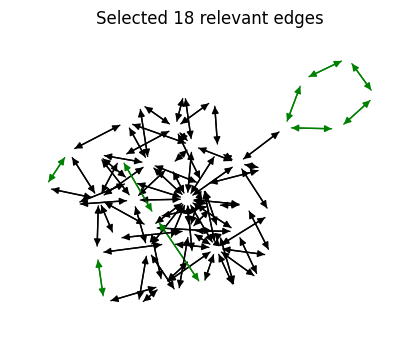

In [15]:
ratio = 0.1
idx = 0

G = graphs_nx["id_val"][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r["id_val"][ratio][idx], spu_subgraphs_r["id_val"][ratio][idx])
num_to_remove = max(1, int(len(G.edges()) * ratio * (1 - config.nec_alpha_1)))
print(f"Removing {num_to_remove} edges")
print(predict_sample([G], tested_pipeline, ratio=ratio).exp())
print(f"GT: {graphs['id_val'][idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(4, 3), nodesize=100, with_labels=False);

In [16]:
metric = "nec"
if metric == "nec++":
    alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
else:
    alpha = config.nec_alpha_1

sampled_G = []
num_samples = 10
orig_predictions = predict_sample([G], tested_pipeline, ratio=ratio).repeat_interleave(num_samples, dim=0)
for j in range(num_samples):
    config.random_seed = 304 + j
    reset_random_seed(config)
    G_sampled, edges_in_gt = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None)
    sampled_G.append((G_sampled, edges_in_gt))
    
predictions = predict_sample([s[0] for s in sampled_G], tested_pipeline, ratio=ratio)


# Compute NEC
div = torch.nn.KLDivLoss(reduction="none", log_target=True)(orig_predictions, predictions).sum(-1)
aggr = 1 - torch.exp(-scatter_mean(div, torch.zeros(predictions.shape[0], dtype=int, device=predictions.device), dim=0)) # on paper


predictions = torch.exp(predictions) # undo the log_softmax
orig_predictions = torch.exp(orig_predictions)
n_row = num_samples // 2
fig, axs = plt.subplots(n_row, 2, figsize=(12,14))
for j in range(num_samples):
    ax = axs[j // 2, j % 2]
    draw(config, sampled_G[j][0], name="", save=False, pos=pos, figsize=(3, 3), nodesize=100, with_labels=False, title=get_title_predition(orig_predictions, predictions, j, graphs[idx].y, sampled_G[j][1]), ax=ax);
plt.suptitle(f"Top-{ratio} final {metric.upper()}: {round(aggr.item(), 3)}")
plt.show()

KeyError: 0

Selected 24 relevant edges over 78


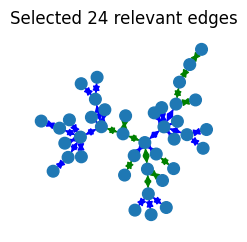

Selected 26 relevant edges over 86


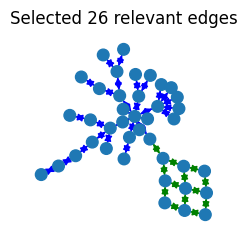

Selected 25 relevant edges over 82


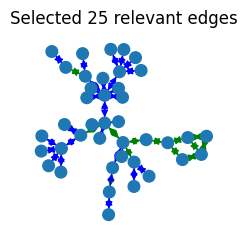

Selected 24 relevant edges over 78


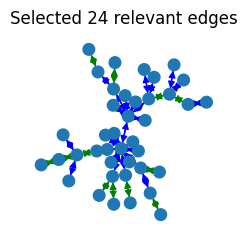

Selected 24 relevant edges over 78


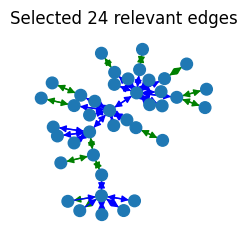

Selected 27 relevant edges over 88


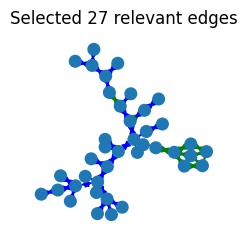

Selected 24 relevant edges over 78


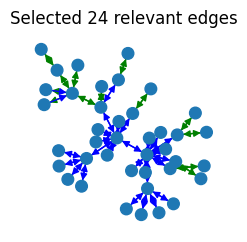

Selected 25 relevant edges over 82


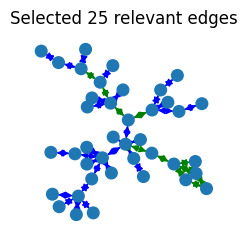

Selected 31 relevant edges over 100


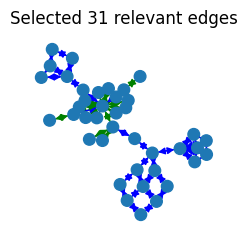

Selected 27 relevant edges over 88


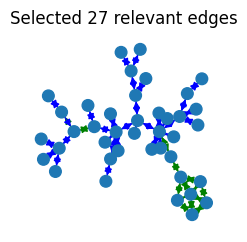

Selected 27 relevant edges over 88


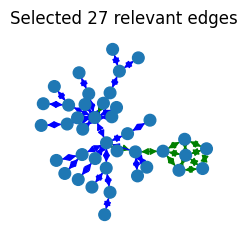

Selected 24 relevant edges over 78


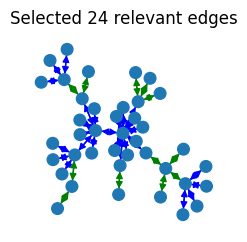

Selected 26 relevant edges over 86


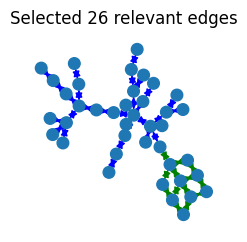

Selected 26 relevant edges over 86


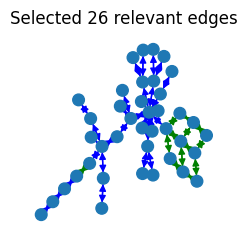

Selected 24 relevant edges over 78


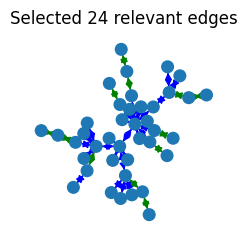

Selected 25 relevant edges over 82


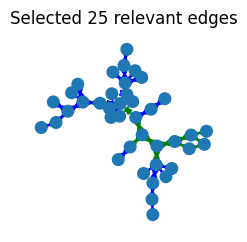

Selected 24 relevant edges over 78


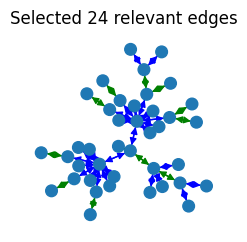

Selected 24 relevant edges over 78


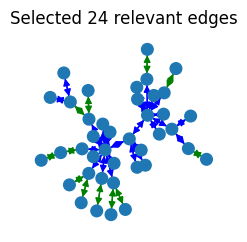

Selected 24 relevant edges over 78


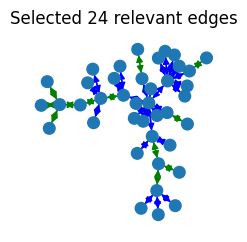

Selected 25 relevant edges over 82


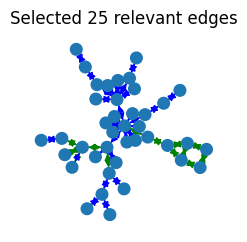

Selected 27 relevant edges over 88


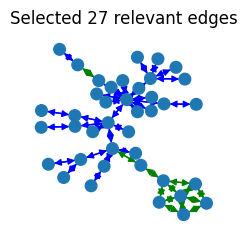

Selected 24 relevant edges over 78


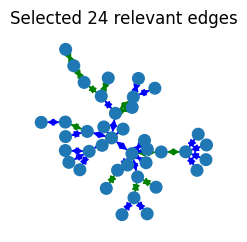

Selected 24 relevant edges over 78


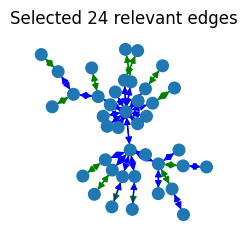

Selected 24 relevant edges over 78


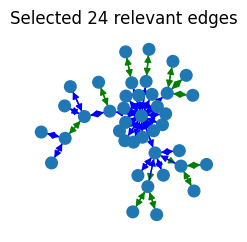

Selected 27 relevant edges over 88


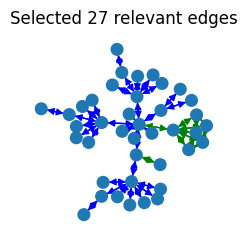

Selected 31 relevant edges over 100


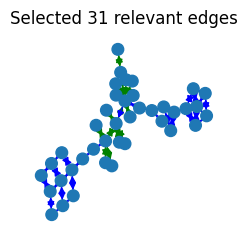

Selected 24 relevant edges over 78


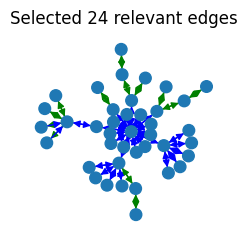

Selected 26 relevant edges over 86


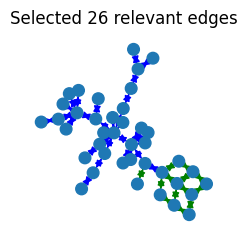

Selected 24 relevant edges over 78


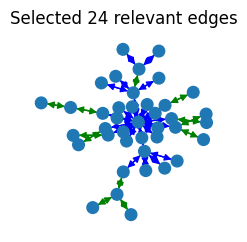

Selected 24 relevant edges over 78


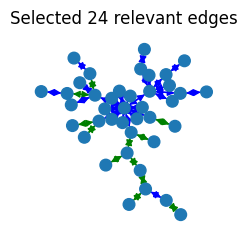

Selected 25 relevant edges over 82


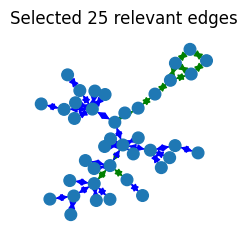

Selected 24 relevant edges over 78


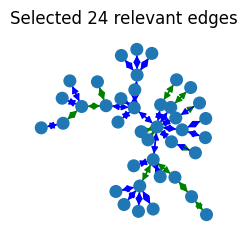

Selected 27 relevant edges over 88


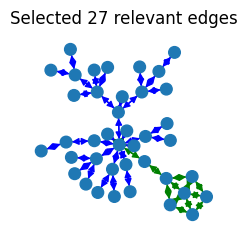

Selected 26 relevant edges over 86


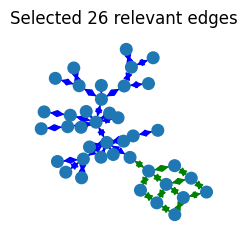

Selected 24 relevant edges over 78


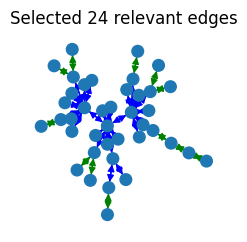

Selected 24 relevant edges over 78


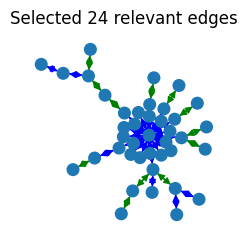

Selected 26 relevant edges over 86


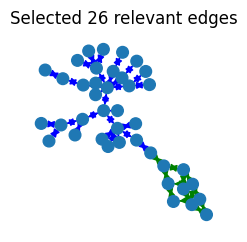

Selected 27 relevant edges over 88


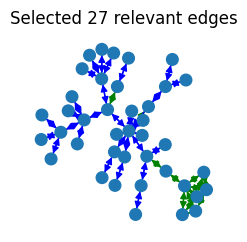

Selected 24 relevant edges over 78


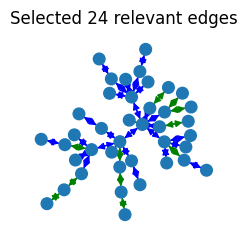

Selected 27 relevant edges over 88


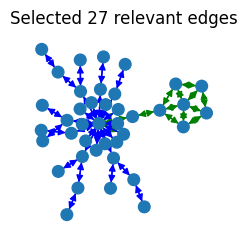

Selected 26 relevant edges over 86


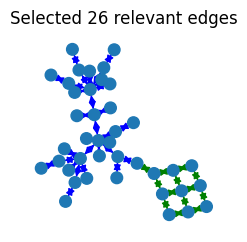

Selected 31 relevant edges over 100


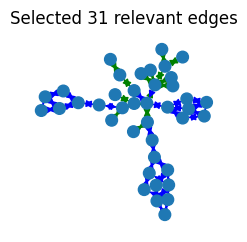

Selected 24 relevant edges over 78


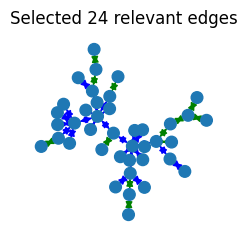

Selected 24 relevant edges over 78


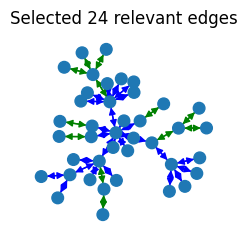

Selected 31 relevant edges over 100


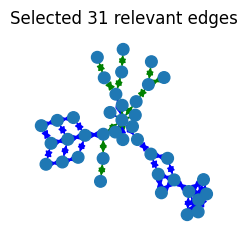

Selected 24 relevant edges over 78


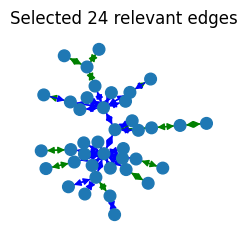

Selected 31 relevant edges over 100


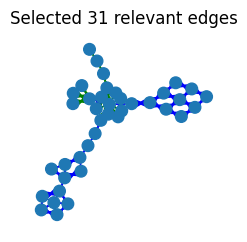

Selected 24 relevant edges over 78


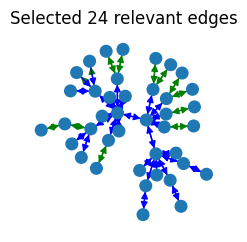

Selected 24 relevant edges over 78


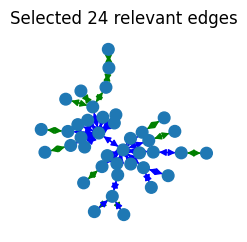

Selected 24 relevant edges over 78


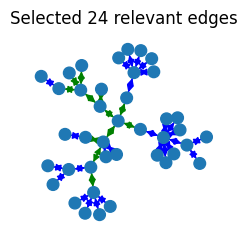

In [43]:
split = "test"
for idx in range(50):
    G = graphs_nx[split][idx].copy()
    xai_utils.mark_edges(G, causal_subgraphs_r[split][ratio][idx], spu_subgraphs_r[split][ratio][idx])
    xai_utils.draw(config, G, name="", save=False, figsize=(2, 2), nodesize=70, with_labels=False);

### Manual investigation

Graph label:  tensor([[1.]])
Num red nodes:  tensor(2.)


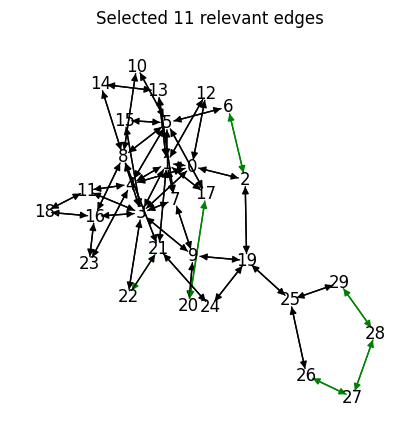

tensor([[1.0000e-10, 1.0000e+00]])
tensor([[0.3827, 0.6173]])


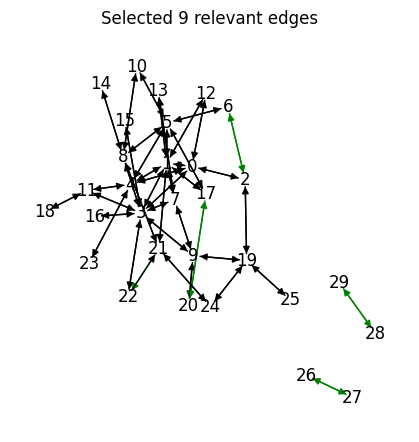

In [24]:
split = "id_val"
ratio = 0.1
idx = 1

print("Graph label: ", graphs[split][idx].y)
print("Num red nodes: ", graphs[split][idx].x.sum(0)[0])

G = graphs_nx[split][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[split][ratio][idx], spu_subgraphs_r[split][ratio][idx])
pos = xai_utils.draw(config, G, name="", save=False, figsize=(4, 4), nodesize=100, with_labels=True);
print(predict_sample([G], tested_pipeline, ratio=None).exp())

# G, _ = sample_edges(G, graphs[split][idx], 0.9, causal_subgraphs_r[split][ratio][idx], ratio=ratio, num_to_remove=1, remove_undirected=True)
# xai_utils.mark_edges(G, causal_subgraphs_r[split][ratio][idx], spu_subgraphs_r[split][ratio][idx])
# xai_utils.draw(config, G, name="", save=False, figsize=(4, 4), nodesize=100, with_labels=True, pos=pos);
# print(predict_sample([G], tested_pipeline, ratio=ratio).exp())

# steve wip
# data_sampled = sample_edges_tensorized(graphs[split][idx], k=1, sampling_type="deconfounded", edge_index_to_remove=causal_masks[split][ratio][idx])
data_sampled = G.copy()

# REMOVE EDGES
for e in [ (27,28), (25,26), (25,29), (16,18), (13,14), (8,16), (16,23), (15,5)]:
    data_sampled.remove_edge(e[0], e[1])
    data_sampled.remove_edge(e[1], e[0])

# ADD EDGES
# data_sampled.add_edge(190, 191, origin="spu")
# data_sampled.add_edge(191, 190, origin="spu")
# data_sampled.nodes[190]["ori_x"] = [0.,0.,1.]
# data_sampled.nodes[191]["ori_x"] = [0.,0.,1.]


data_sampled = from_networkx(data_sampled)
print(predict_sample([data_sampled], tested_pipeline, ratio=None).exp())
G = to_networkx(data_sampled)
xai_utils.mark_edges(G, causal_subgraphs_r[split][ratio][idx], spu_subgraphs_r[split][ratio][idx])
xai_utils.draw(config, G, name="", save=False, figsize=(4, 4), nodesize=100, with_labels=True, pos=pos);

## NEC analysis

In [45]:
metric = "nec"
alpha = 0.95 #config.nec_alpha_1

SPLIT = "id_val"
num_samples = 10
num_seeds = 2
necs, change_of_pred, fid_label, fid_unsup, fid_div, rfid, rfid_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
nec_l1, necs_bernoulli = defaultdict(list), defaultdict(list)
necs_per_class = defaultdict(lambda: defaultdict(list))
preds, ori_preds = defaultdict(dict), defaultdict(dict)
metrics = defaultdict(lambda: defaultdict(list))
idxs, _ = train_test_split(
    np.arange(len(graphs[SPLIT])),
    train_size=50,
    random_state=42,
    shuffle=True,
    stratify=[graphs[SPLIT][i].y.item() for i in range(len(graphs[SPLIT]))]
)
for ratio in ratios:    
    for seed in range(num_seeds):        
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[SPLIT][idx].copy()
            if len(G.edges()) == 0 or len(G.nodes()) == 0:
                continue
            labels_norep = torch.cat((labels_norep, graphs[SPLIT][idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)

                G_sampled, edges_in_gt = sample_edges(G, graphs[SPLIT][idx], alpha, causal_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=int((1-alpha)*avg_graph_size[SPLIT]), remove_undirected=True)
                G_sampledK1, _ = sample_edges(G, graphs[SPLIT][idx], alpha, causal_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=1, remove_undirected=True)
                # G_sampled_rfid, _ = sample_edges_rfid(G, graphs[SPLIT][idx], alpha, causal_subgraphs_r[SPLIT][ratio][idx])
                G_sampled_rfid      = sample_edges_tensorized(graphs[SPLIT][idx], k=None, sampling_type="bernoulli", edge_index_to_remove=causal_masks[SPLIT][ratio][idx], alpha=0.5)
                G_sampled_more, _ = sample_edges(G, graphs[SPLIT][idx], alpha, causal_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=int((1-alpha)*3*avg_graph_size[SPLIT]), remove_undirected=True)
                data_sampled = sample_edges_tensorized(graphs[SPLIT][idx], k=1, sampling_type="deconfounded", edge_index_to_remove=causal_masks[SPLIT][ratio][idx])

                sampled.append((G_sampled, G_sampled_rfid, G_sampledK1, G_sampled_more, data_sampled, edges_in_gt))
                ori_graphs.append((G, np.nan))
                belonging.append(idx)
                labels = torch.cat((labels, graphs[SPLIT][idx].y), dim=0)
            
        pred_all = predict_sample([s[0] for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled] + [s[2] for s in sampled] + [s[3] for s in sampled] + [s[4] for s in sampled], tested_pipeline, ratio=ratio)
        ori_pred = pred_all[:len(ori_graphs)]
        pred = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_rfid = pred_all[len(ori_graphs) + len(sampled):len(ori_graphs) + 2*len(sampled)]
        predK1 = pred_all[len(ori_graphs) + 2*len(sampled):len(ori_graphs) + 3*len(sampled)]
        predMore = pred_all[len(ori_graphs) + 3*len(sampled):len(ori_graphs) + 4*len(sampled)]
        predTensorK1 = pred_all[len(ori_graphs) + 4*len(sampled):]

        ori_preds[ratio][seed] = ori_pred
        preds[ratio][seed] = pred
        labels = labels.view(-1)
        
        belonging = normalize_belonging(belonging).to(pred.device)

        def nec_kl(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred).sum(-1), belonging, dim=0))
        def nec_l1(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.abs(ori_pred.exp() - pred.exp()).sum(-1), belonging, dim=0))
        def fid_l1_div(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()
        def fid_model(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()
        def fid_phenom(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred.exp().gather(1, labels.long().unsqueeze(1))).mean()
        def ratio_pred_change(ori_pred, pred, belonging, labels):
            return sum(ori_pred.argmax(-1) != pred.argmax(-1)) / pred.shape[0]

        divergences = {"alphaAvgG": {}, "always1": {}, "bernoulli": {}, "alphaAvgGMore":{}, "always1Tensor":{}}
        for metric_name, div_f in zip(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID", "Change pred"], [nec_kl, nec_l1, fid_l1_div, fid_model, fid_phenom, ratio_pred_change]):
            divergences["alphaAvgG"][metric_name]        = div_f(ori_pred, pred, belonging, labels).mean().item()
            divergences["alphaAvgGMore"][metric_name]    = div_f(ori_pred, predMore, belonging, labels).mean().item()
            divergences["always1"][metric_name]          = div_f(ori_pred, predK1, belonging, labels).mean().item()
            divergences["bernoulli"][metric_name]        = div_f(ori_pred, pred_rfid, belonging, labels).mean().item()
            divergences["always1Tensor"][metric_name]    = div_f(ori_pred, predTensorK1, belonging, labels).mean().item()

        metrics[ratio][seed] = divergences
        accs[ratio].append(sum(labels.view(-1) == ori_pred.argmax(-1)) / pred.shape[0])
        aggr = nec_kl(ori_pred, pred, belonging, labels=None)
        for c in range(3):
            necs_per_class[ratio][c].append(aggr[labels_norep.view(-1) == c].mean().item())        
        
        # div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred).sum(-1)
        # aggr = 1 - torch.exp(-scatter_mean(div, belonging, dim=0))
        # div_l1 = torch.abs(ori_pred.exp() - pred.exp()).sum(-1)
        # aggr_l1 = 1 - torch.exp(-scatter_mean(div_l1, belonging, dim=0))
        # div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_rfid).sum(-1)
        # aggr_bernoulli = 1 - torch.exp(-scatter_mean(div, belonging, dim=0))
        # change_of_pred[ratio].append(sum(ori_pred.argmax(-1) != pred.argmax(-1)) / pred.shape[0])        
        # necs[ratio].append(aggr.mean().item())
        # fid_label[ratio].append(torch.abs(ori_pred.exp().gather(1, labels.view(-1).long().unsqueeze(1)) - pred.exp().gather(1, labels.view(-1).long().unsqueeze(1))).mean()) # NEC with d=L1 wrt Phenomenon
        # fid_unsup[ratio].append(torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()) # NEC with d=L1 wrt Model
        # fid_div[ratio].append(torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()) # NEC with d=L1 wrt the entire distribution
        # nec_l1[ratio].append(aggr_l1.mean().item())
        # rfid[ratio].append(torch.abs(ori_pred.exp().gather(1, labels.view(-1).long().unsqueeze(1)) - pred_rfid.exp().gather(1, labels.view(-1).long().unsqueeze(1))).mean())
        # rfid_div[ratio].append(torch.abs(ori_pred.exp() - pred_rfid.exp()).sum(-1).mean())
        # necs_bernoulli[ratio].append(aggr_bernoulli.mean().item())

KeyError: 'num_nodes'

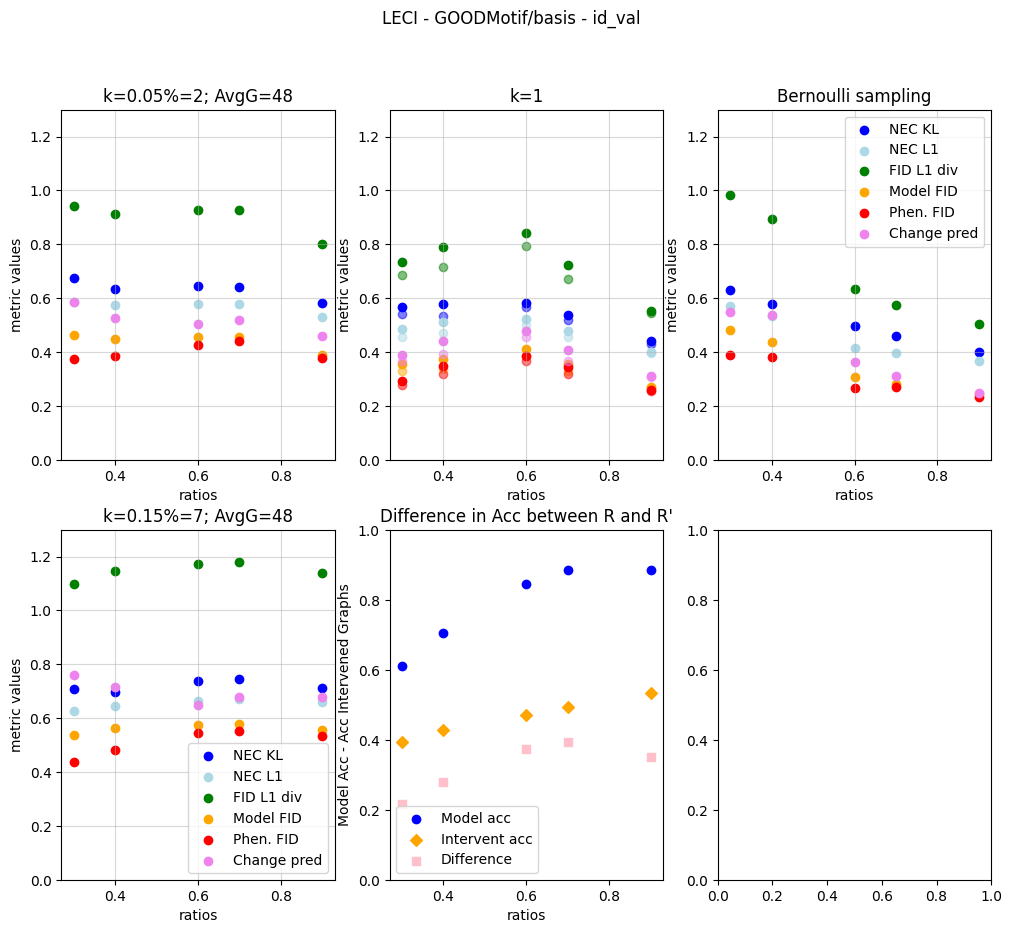

In [180]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))

colors = {
    "NEC KL": "blue", "NEC L1":"lightblue", "FID L1 div": "green", "Model FID": "orange", "Phen. FID": "red", "Change pred": "violet"
}
for r in ratios:
    for i, metric_name in enumerate(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID", "Change pred"]):
        axs[0,0].scatter(r, np.mean([metrics[r][s]["alphaAvgG"][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name])
    # axs[0,0].scatter(r, np.mean(necs[r]) + np.std(necs[r]), c="r", marker="v")
axs[0,0].grid(visible=True, alpha=0.5)
axs[0,0].set_title(f"k={1-alpha:.2f}%={int((1-alpha)*avg_graph_size[SPLIT])}; AvgG={int(avg_graph_size[SPLIT])}")
axs[0,0].set_xlabel("ratios")
axs[0,0].set_ylabel("metric values")
axs[0,0].set_ylim((0., 1.3))

for r in ratios:
    for i, metric_name in enumerate(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID", "Change pred"]):
        axs[0,1].scatter(r, np.mean([metrics[r][s]["always1"][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name])
        axs[0,1].scatter(r, np.mean([metrics[r][s]["always1Tensor"][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name], alpha=0.5)
axs[0,1].grid(visible=True, alpha=0.5)
axs[0,1].set_title("k=1")
axs[0,1].set_xlabel("ratios")
axs[0,1].set_ylabel("metric values")
axs[0,1].set_ylim((0., 1.3))

for r in ratios:
    for i, metric_name in enumerate(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID", "Change pred"]):
        axs[0,2].scatter(r, np.mean([metrics[r][s]["bernoulli"][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name])
axs[0,2].grid(visible=True, alpha=0.5)
axs[0,2].legend(loc='best')
axs[0,2].set_title("Bernoulli sampling")
axs[0,2].set_xlabel("ratios")
axs[0,2].set_ylabel("metric values")
axs[0,2].set_ylim((0., 1.3))

for r in ratios:
    for i, metric_name in enumerate(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID", "Change pred"]):
        axs[1,0].scatter(r, np.mean([metrics[r][s]["alphaAvgGMore"][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name])
axs[1,0].grid(visible=True, alpha=0.5)
axs[1,0].legend(loc='best')
axs[1,0].set_title(f"k={(1-alpha)*3:.2f}%={int((1-alpha)*3*avg_graph_size[SPLIT])}; AvgG={int(avg_graph_size[SPLIT])}")
axs[1,0].set_xlabel("ratios")
axs[1,0].set_ylabel("metric values")
axs[1,0].set_ylim((0., 1.3))


for r in ratios:
    axs[1,1].scatter(r, np.mean(accs[r]), c="blue", label="Model acc" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)]), marker="D", c="orange", label="Intervent acc" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean(accs[r]) - np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)]), c="pink", marker="s", label="Difference" if r == 0.3 else None)
axs[1,1].legend()
axs[1,1].set_title("Difference in Acc between R and R'")
axs[1,1].set_xlabel("ratios")
axs[1,1].set_ylabel("Model Acc - Acc Intervened Graphs")
axs[1,1].set_ylim((0., 1.))
plt.suptitle(f"{MODEL} - {DATASET} - {SPLIT}")
plt.show();

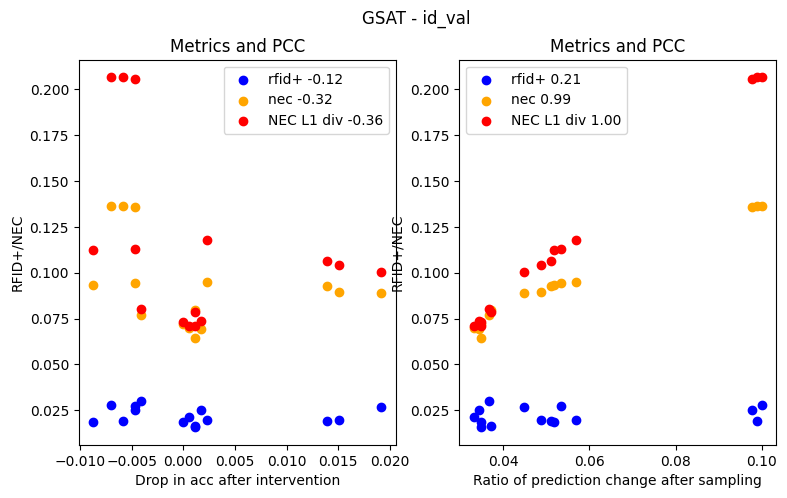

In [136]:
# Pearson correlation
acc_diff = [[accs[r][i] - accuracy_score(labels.view(-1), preds[r][i].argmax(-1))] for r in ratios for i in range(num_seeds)]
ratio_change_pred = [[change_of_pred[r][i]] for r in ratios for i in range(num_seeds)]
nec_plot =[necs[r][i] for r in ratios for i in range(num_seeds)]
fid_plot = [rfid[r][i] for r in ratios for i in range(num_seeds)]
nec_l1_plot = [fid_div[r][i] for r in ratios for i in range(num_seeds)]

pcc_fid = r_regression(acc_diff, fid_plot)[0]
pcc_nec = r_regression(acc_diff, nec_plot)[0]
pcc_necl1 = r_regression(acc_diff, nec_l1_plot)[0]

pcc_fid2 = r_regression(ratio_change_pred, fid_plot)[0]
pcc_nec2 = r_regression(ratio_change_pred, nec_plot)[0]
pcc_necl12 = r_regression(ratio_change_pred, nec_l1_plot)[0]


fig, axs = plt.subplots(1, 2, figsize=(9, 5))

axs[0].scatter(acc_diff, fid_plot, c="blue", label=f"rfid+ {pcc_fid:.2f}")
axs[0].scatter(acc_diff, nec_plot, c="orange", label=metric + f" {pcc_nec:.2f}")
axs[0].scatter(acc_diff, nec_l1_plot, c="red", label=f"NEC L1 div {pcc_necl1:.2f}")

axs[0].legend()
axs[0].set_title(f"Metrics and PCC")
axs[0].set_xlabel("Drop in acc after intervention")
axs[0].set_ylabel(f"RFID+/{metric.upper()}")


axs[1].scatter(ratio_change_pred, fid_plot, c="blue", label=f"rfid+ {pcc_fid2:.2f}")
axs[1].scatter(ratio_change_pred, nec_plot, c="orange", label=metric + f" {pcc_nec2:.2f}")
axs[1].scatter(ratio_change_pred, nec_l1_plot, c="red", label=f"NEC L1 div {pcc_necl12:.2f}")

axs[1].legend()
axs[1].set_title(f"Metrics and PCC")
axs[1].set_xlabel("Ratio of prediction change after sampling")
axs[1].set_ylabel(f"RFID+/{metric.upper()}")

plt.suptitle(f"{MODEL} - {SPLIT}")
plt.show()



Class-wise plot

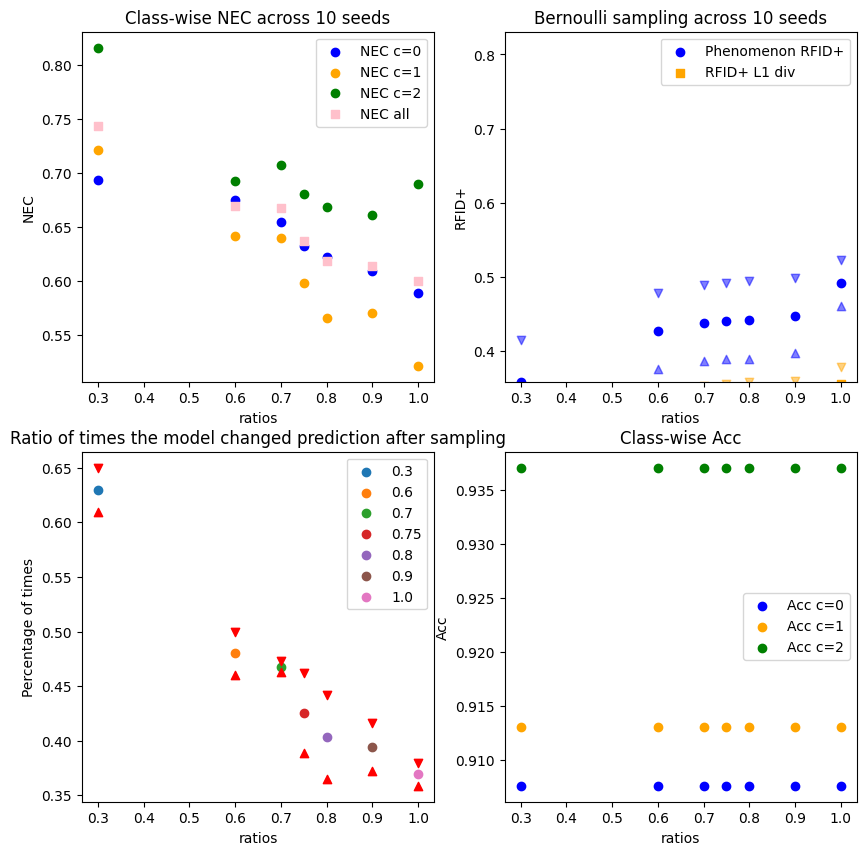

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

colors_c = {
    0: "blue",
    1: "orange",
    2: "green",
}
for r in ratios:
    sas = np.array([necs_per_class[r][c] for c in range(3)])
    for c in range(3):
        axs[0,0].scatter(r, np.mean(sas, axis=1)[c], label=f"{metric.upper()} c={c}" if r == 0.3 else None, c=colors_c[c])
    axs[0,0].scatter(r, np.mean(np.mean(sas, axis=1)), label=f"{metric.upper()} all" if r == 0.3 else None, c="pink", marker="s")
axs[0,0].legend()
axs[0,0].set_title(f"Class-wise {metric.upper()} across 10 seeds")
axs[0,0].set_xlabel("ratios")
axs[0,0].set_ylabel(metric.upper())

for r in ratios:
    axs[0,1].scatter(r, np.mean(rfid[r]), label="Phenomenon RFID+" if r == 0.3 else None, c="blue",)
    axs[0,1].scatter(r, np.mean(rfid[r]) + np.std(rfid[r]), c="blue", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid[r]) - np.std(rfid[r]), c="blue", marker="^", alpha=0.5)
    
    axs[0,1].scatter(r, np.mean(rfid_div[r]), c="orange", marker="s", label="RFID+ L1 div" if r == 0.3 else None)
    axs[0,1].scatter(r, np.mean(rfid_div[r]) + np.std(rfid_div[r]), c="orange", marker="v", alpha=0.5)
    axs[0,1].scatter(r, np.mean(rfid_div[r]) - np.std(rfid_div[r]), c="orange", marker="^", alpha=0.5)
axs[0,1].legend()
axs[0,1].set_title("Bernoulli sampling across 10 seeds")
axs[0,1].set_xlabel("ratios")
axs[0,1].set_ylabel("RFID+")
axs[0,1].set_ylim((min(np.mean(rfid[0.3]), axs[0,0].get_ylim()[0]), axs[0,0].get_ylim()[1]))

for r in ratios:
    axs[1,0].scatter(r, np.mean(change_of_pred[r]), label=r)
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) + np.std(change_of_pred[r]), c="r", marker="v")
    axs[1,0].scatter(r, np.mean(change_of_pred[r]) - np.std(change_of_pred[r]), c="r", marker="^")
axs[1,0].legend()
axs[1,0].set_title("Ratio of times the model changed prediction after sampling")
axs[1,0].set_xlabel("ratios")
axs[1,0].set_ylabel("Percentage of times")

colors_r = {
    0.3: "blue",
    0.6: "orange",
    0.9: "green",
}
colors_c2 = {
    0: "black",
    1: "pink",
    2: "salmon",
}
for r in ratios:
    sas = [f1_score((labels == c).long(), (ori_preds[r][0].argmax(-1) == c).long()) for c in range(3)]
    # sas_int = [f1_score((labels == c).long(), (preds[r][0].argmax(-1) == c).long()) for c in range(3)]
    for c in range(3):
        axs[1,1].scatter(r, sas[c], c=colors_c[c], label=f"Acc c={c}" if r == 0.3 else None)
        # axs[1,1].scatter(r, sas_int[c], c=colors_c[c], label=f"Int. Acc c={c}" if r == 0.3 else None, alpha=0.5)
    # axs[1,1].scatter(r, np.mean(accs[r]) - accuracy_score(labels, preds[r][0].argmax(-1)), c="pink", marker="s", label="Difference" if r == 0.3 else None)
axs[1,1].legend()
axs[1,1].set_title("Class-wise Acc")
axs[1,1].set_xlabel("ratios")
axs[1,1].set_ylabel("Acc")
plt.show();

### Compare Bernoulli directed/undirected

In [10]:
metric = "nec"
alpha = 0.05

SPLIT = "test"
num_samples = 10
num_seeds = 3
necs, change_of_pred, fid_label, fid_unsup, fid_div, rfid, rfid_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
nec_l1, necs_bernoulli = defaultdict(list), defaultdict(list)
necs_per_class = defaultdict(lambda: defaultdict(list))
preds, ori_preds = defaultdict(dict), defaultdict(dict)
metrics = defaultdict(lambda: defaultdict(list))
for ratio in ratios:    
    for seed in range(num_seeds):
        idxs, _ = train_test_split(
            np.arange(len(graphs[SPLIT])),
            train_size=200,
            random_state=42 + seed*10,
            shuffle=True,
            stratify=[graphs[SPLIT][i].y.item() for i in range(len(graphs[SPLIT]))]
        )
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[SPLIT][idx].copy()
            if len(G.edges()) == 0 or len(G.nodes()) == 0 or graphs[SPLIT][idx].edge_index.shape[1] <= 2:
                continue
            labels_norep = torch.cat((labels_norep, graphs[SPLIT][idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)

                G_sampledK1          = sample_edges_tensorized(graphs[SPLIT][idx], k=1, sampling_type="deconfounded", edge_index_to_remove=causal_masks[SPLIT][ratio][idx])
                G_sampledK3          = sample_edges_tensorized(graphs[SPLIT][idx], k=3, sampling_type="deconfounded", edge_index_to_remove=causal_masks[SPLIT][ratio][idx])
                G_sampledK5          = sample_edges_tensorized(graphs[SPLIT][idx], k=5, sampling_type="deconfounded", edge_index_to_remove=causal_masks[SPLIT][ratio][idx])
                G_sampled_rfid_nx, _ = sample_edges_rfid(G, graphs[SPLIT][idx], alpha, causal_subgraphs_r[SPLIT][ratio][idx], force_undirected=True)
                G_sampled_rfid_undir = sample_edges_tensorized(graphs[SPLIT][idx], alpha=alpha, sampling_type="bernoulli", edge_index_to_remove=causal_masks[SPLIT][ratio][idx], force_undirected=True)
                G_sampled_rfid_dir   = sample_edges_tensorized(graphs[SPLIT][idx], alpha=alpha, sampling_type="bernoulli", edge_index_to_remove=causal_masks[SPLIT][ratio][idx], force_undirected=False)
                G_sampled_rfid_undir_a2 = sample_edges_tensorized(graphs[SPLIT][idx], alpha=alpha*2, sampling_type="bernoulli", edge_index_to_remove=causal_masks[SPLIT][ratio][idx], force_undirected=True)
                G_sampled_rfid_undir_a4 = sample_edges_tensorized(graphs[SPLIT][idx], alpha=alpha*4, sampling_type="bernoulli", edge_index_to_remove=causal_masks[SPLIT][ratio][idx], force_undirected=True)

                sampled.append((G_sampled_rfid_nx, G_sampledK1, G_sampled_rfid_undir, G_sampled_rfid_dir, G_sampledK3, G_sampled_rfid_undir_a2, G_sampled_rfid_undir_a4, G_sampledK5))
                ori_graphs.append(graphs[SPLIT][idx])
                belonging.append(idx)
                labels = torch.cat((labels, graphs[SPLIT][idx].y), dim=0)
            
        pred_all = predict_sample([s for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled] + [s[2] for s in sampled] + [s[3] for s in sampled] + [s[4] for s in sampled] + [s[5] for s in sampled] + [s[6] for s in sampled] + [s[7] for s in sampled], tested_pipeline, ratio=ratio)
        ori_pred = pred_all[:len(ori_graphs)]
        pred_rfid_nx = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_K1 = pred_all[len(ori_graphs) + len(sampled):len(ori_graphs) + 2*len(sampled)]
        pred_rfid_undir = pred_all[len(ori_graphs) + 2*len(sampled):len(ori_graphs) + 3*len(sampled)]
        pred_rfid_dir = pred_all[len(ori_graphs) + 3*len(sampled):len(ori_graphs) + 4*len(sampled)]
        pred_K3 = pred_all[len(ori_graphs) + 4*len(sampled):len(ori_graphs) + 5*len(sampled)]
        pred_rfid_undir_a2 = pred_all[len(ori_graphs) + 5*len(sampled):len(ori_graphs) + 6*len(sampled)]
        pred_rfid_undir_a4 = pred_all[len(ori_graphs) + 6*len(sampled):len(ori_graphs) + 7*len(sampled)]
        pred_K5 = pred_all[len(ori_graphs) + 7*len(sampled):len(ori_graphs) + 8*len(sampled)]

        ori_preds[ratio][seed] = ori_pred # preds[ratio][seed] = pred
        labels = labels.view(-1)        
        belonging = normalize_belonging(belonging).to(ori_pred.device)

        def nec_kl(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred).sum(-1), belonging, dim=0))
        def nec_l1(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.abs(ori_pred.exp() - pred.exp()).sum(-1), belonging, dim=0))
        def fid_l1_div(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()
        def fid_model(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()
        def fid_phenom(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred.exp().gather(1, labels.long().unsqueeze(1))).mean()
        def ratio_pred_change(ori_pred, pred, belonging, labels):
            return sum(ori_pred.argmax(-1) != pred.argmax(-1)) / pred.shape[0]

        divergences = {"rfid_nx": {}, "always1": {}, "rfid_undir": {}, "rfid_dir":{}, "always3": {}, "always5": {}, "rfid_undir_a2": {}, "rfid_undir_a4": {}}
        for metric_name, div_f in zip(["NEC KL", "NEC L1", "FID L1 div", "Change pred"], [nec_kl, nec_l1, fid_l1_div, ratio_pred_change]): #"Model FID", "Phen. FID", 
            divergences["rfid_nx"][metric_name]        = div_f(ori_pred, pred_rfid_nx, belonging, labels).mean().item()
            divergences["always1"][metric_name]        = div_f(ori_pred, pred_K1, belonging, labels).mean().item()
            divergences["always3"][metric_name]        = div_f(ori_pred, pred_K3, belonging, labels).mean().item()
            divergences["always5"][metric_name]        = div_f(ori_pred, pred_K5, belonging, labels).mean().item()
            divergences["rfid_undir"][metric_name]     = div_f(ori_pred, pred_rfid_undir, belonging, labels).mean().item()
            divergences["rfid_undir_a2"][metric_name]  = div_f(ori_pred, pred_rfid_undir_a2, belonging, labels).mean().item()
            divergences["rfid_undir_a4"][metric_name]  = div_f(ori_pred, pred_rfid_undir_a4, belonging, labels).mean().item()
            divergences["rfid_dir"][metric_name]       = div_f(ori_pred, pred_rfid_dir, belonging, labels).mean().item()

        metrics[ratio][seed] = divergences
        accs[ratio].append(sum(labels.view(-1) == ori_pred.argmax(-1)) / ori_pred.shape[0])

ValueError: Empty intervened graph

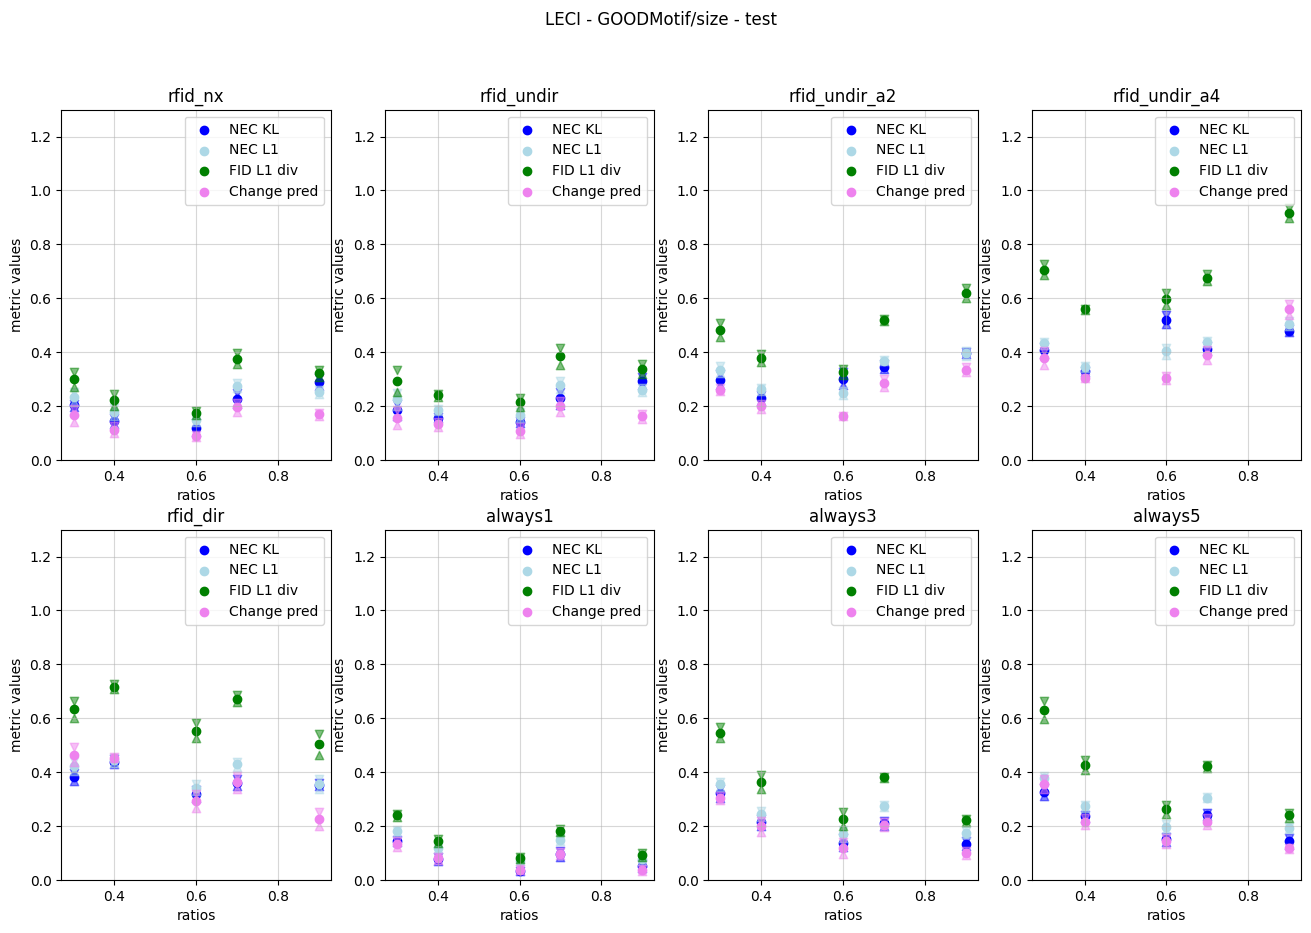

In [18]:
num_cols = 4  
fig, axs = plt.subplots(2, num_cols, figsize=(16, 10))

colors = {
    "NEC KL": "blue", "NEC L1":"lightblue", "FID L1 div": "green", "Model FID": "orange", "Phen. FID": "red", "Change pred": "violet"
}

for j, sampling_type in enumerate(["rfid_nx", "rfid_undir", "rfid_undir_a2", "rfid_undir_a4", "rfid_dir", "always1", "always3", "always5"]):
    for r in ratios:
        for i, metric_name in enumerate(["NEC KL", "NEC L1", "FID L1 div", "Change pred"]):
            axs[j//num_cols,j%num_cols].scatter(r, np.mean([metrics[r][s][sampling_type][metric_name] for s in range(num_seeds)]), label=f"{metric_name}" if r == 0.3 else None, c=colors[metric_name])
            axs[j//num_cols,j%num_cols].scatter(r, np.mean([metrics[r][s][sampling_type][metric_name] for s in range(num_seeds)]) - np.std([metrics[r][s][sampling_type][metric_name] for s in range(num_seeds)]), c=colors[metric_name], alpha=.5, marker="^")
            axs[j//num_cols,j%num_cols].scatter(r, np.mean([metrics[r][s][sampling_type][metric_name] for s in range(num_seeds)]) + np.std([metrics[r][s][sampling_type][metric_name] for s in range(num_seeds)]), c=colors[metric_name], alpha=.5, marker="v")
    axs[j//num_cols,j%num_cols].grid(visible=True, alpha=0.5)
    axs[j//num_cols,j%num_cols].set_title(f"{sampling_type}")
    axs[j//num_cols,j%num_cols].set_xlabel("ratios")
    axs[j//num_cols,j%num_cols].set_ylabel("metric values")
    axs[j//num_cols,j%num_cols].set_ylim((0., 1.3))
    axs[j//num_cols,j%num_cols].legend(loc='best')

plt.suptitle(f"{MODEL} - {DATASET} - {SPLIT}")
plt.show();

### Compare different sampling for NEC div

In [37]:
metric = "nec"
if metric == "nec++":
    alpha = max(config.nec_alpha_1 - 0.1 * (j // 3), 0.1)
else:
    alpha = config.nec_alpha_1

num_samples = 5
num_seeds = 1
# necs, change_of_pred, fid_label, fid_unsup, fid_div, rfid, rfid_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
# nec_l1, necs_bernoulli = defaultdict(list), defaultdict(list)
# necs_per_class = defaultdict(lambda: defaultdict(list))
# preds, ori_preds = defaultdict(dict), defaultdict(dict)
metrics = defaultdict(lambda: defaultdict(list))
accs = defaultdict(list)
idxs, _ = train_test_split(
    np.arange(len(graphs)),
    train_size=100,
    random_state=42,
    shuffle=True,
    stratify=[graphs[i].y.item() for i in range(len(graphs))]
)
for ratio in ratios:    
    for seed in range(num_seeds):        
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[idx].copy()
            if len(G.edges()) == 0 or len(G.nodes()) == 0:
                continue
            labels_norep = torch.cat((labels_norep, graphs[idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)
                
                G_sampled_alphaG, _           = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_loweralphaG, _      = sample_edges(G, graphs[idx], alpha/2, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_alphaGundirected, _ = sample_edges(G, graphs[idx], alpha/2, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=True)
                G_sampled_always1, _          = sample_edges(G, graphs[idx], alpha, causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=100, remove_undirected=False)
                G_sampled_necpp, _            = sample_edges(G, graphs[idx], max(config.nec_alpha_1-0.1*(j // 3), 0.1), causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                G_sampled_necpp2, _           = sample_edges(G, graphs[idx], max((config.nec_alpha_1 + 0.05)-0.05*(j // 2), 0.1), causal_subgraphs_r[ratio][idx], ratio=1, num_to_remove=None, remove_undirected=False)
                
                sampled.append((G_sampled_alphaG, G_sampled_loweralphaG, G_sampled_alphaGundirected, G_sampled_always1, G_sampled_necpp, G_sampled_necpp2))
                ori_graphs.append((G, np.nan))
                belonging.append(idx)
                labels = torch.cat((labels, graphs[idx].y), dim=0)
            
        pred_all = predict_sample(
            [s[0] for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled] + [s[2] for s in sampled] + [s[3] for s in sampled] + [s[4] for s in sampled] + [s[5] for s in sampled],
            tested_pipeline,
            ratio=ratio
        )
        ori_pred = pred_all[:len(ori_graphs)]
        
        pred_alphaG = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_loweralphaG = pred_all[len(ori_graphs) + len(sampled): len(ori_graphs) + 2*len(sampled)]
        pred_alphaGundirected = pred_all[len(ori_graphs) + 2*len(sampled): len(ori_graphs) + 3*len(sampled)]
        pred_always1 = pred_all[len(ori_graphs) + 3*len(sampled): len(ori_graphs) + 4*len(sampled)]
        pred_necpp = pred_all[len(ori_graphs) + 4*len(sampled): len(ori_graphs) + 5*len(sampled)]
        pred_necpp2 = pred_all[len(ori_graphs) + 5*len(sampled): len(ori_graphs) + 6*len(sampled)]
        
        belonging = normalize_belonging(belonging).to(pred_alphaG.device)

        def nec_kl(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred).sum(-1), belonging, dim=0))
        def nec_l1(ori_pred, pred, belonging, labels):
            return 1 - torch.exp(-scatter_mean(torch.abs(ori_pred.exp() - pred.exp()).sum(-1), belonging, dim=0))
        def fid_l1_div(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()
        def fid_model(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1)) - pred.exp().gather(1, ori_pred.argmax(-1).unsqueeze(1))).mean()
        def fid_phenom(ori_pred, pred, belonging, labels):
            return torch.abs(ori_pred.exp().gather(1, labels.long().unsqueeze(1)) - pred.exp().gather(1, labels.long().unsqueeze(1))).mean()

        divergences = {
            "alphaG": {},
            "loweralphaG": {},
            "alphaGundirected": {},
            "always1": {},
            "nec++": {},
            "nec++2": {},
        }
        for metric_name, div_f in zip(["NEC KL", "NEC L1", "FID L1 div", "Model FID", "Phen. FID"], [nec_kl, nec_l1, fid_l1_div, fid_model, fid_phenom]):
            divergences["alphaG"][metric_name]           = div_f(ori_pred, pred_alphaG, belonging, labels.view(-1)).mean().item()
            divergences["loweralphaG"][metric_name]      = div_f(ori_pred, pred_loweralphaG, belonging, labels.view(-1)).mean().item()
            divergences["alphaGundirected"][metric_name] = div_f(ori_pred, pred_alphaGundirected, belonging, labels.view(-1)).mean().item()
            divergences["always1"][metric_name]          = div_f(ori_pred, pred_always1, belonging, labels.view(-1)).mean().item()
            divergences["nec++"][metric_name]            = div_f(ori_pred, pred_necpp, belonging, labels.view(-1)).mean().item()
            divergences["nec++2"][metric_name]           = div_f(ori_pred, pred_necpp2, belonging, labels.view(-1)).mean().item()

        metrics[ratio][seed] = divergences
        accs[ratio].append(sum(labels.view(-1) == ori_pred.argmax(-1)) / ori_pred.shape[0])

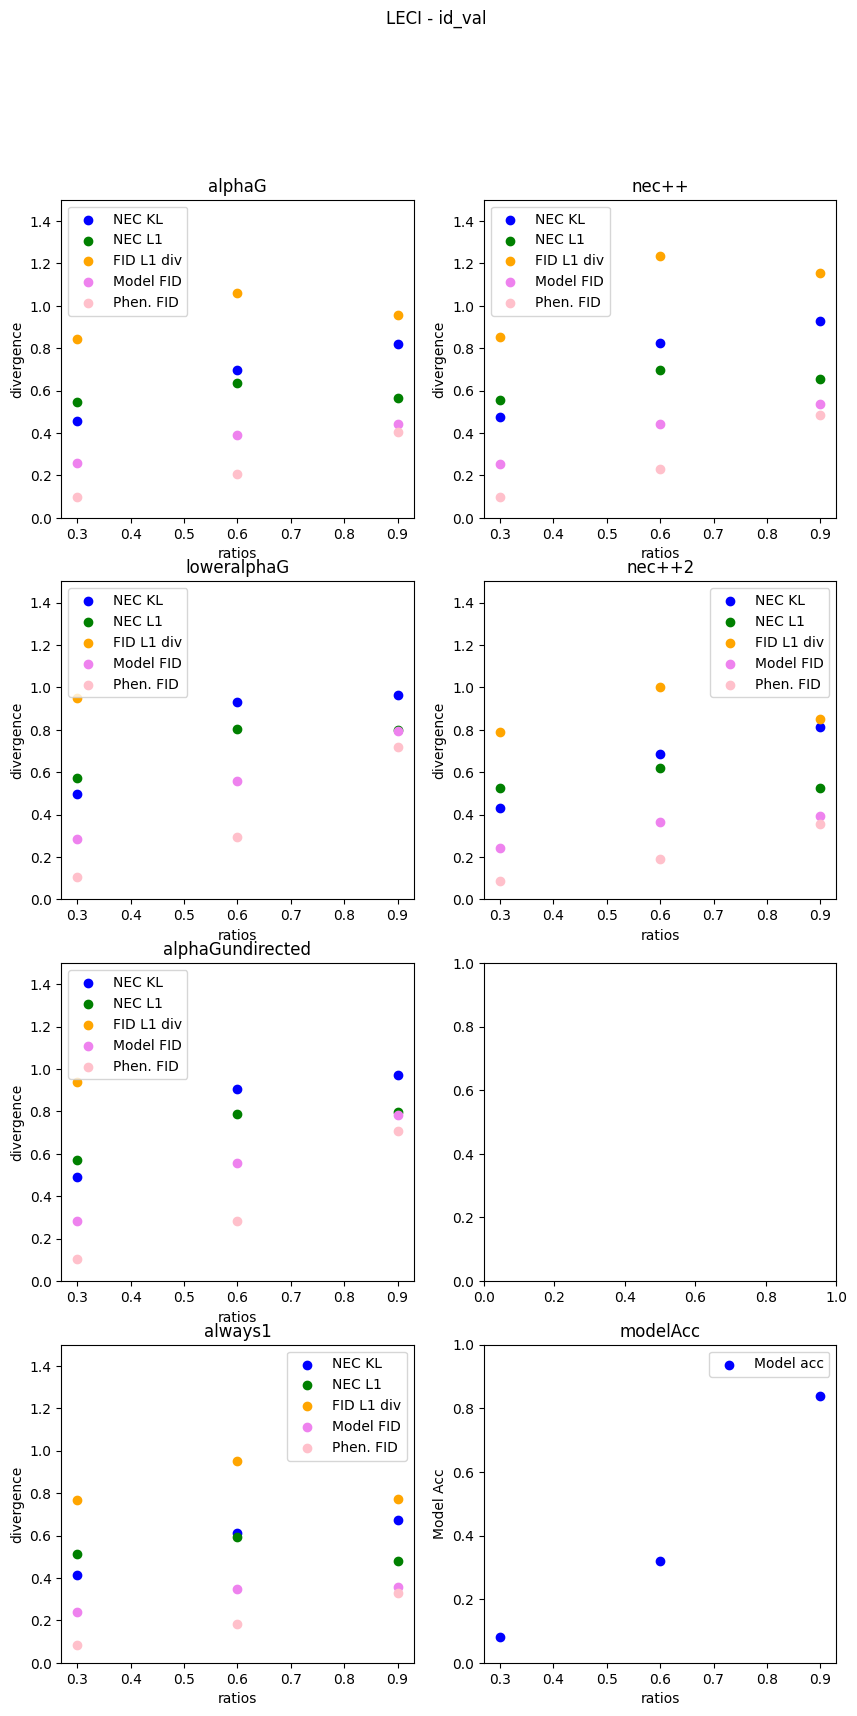

In [38]:
num_rows = 4
fig, axs = plt.subplots(num_rows, 2, figsize=(10, 19))

for i, method in enumerate(["alphaG", "loweralphaG", "alphaGundirected", "always1", "nec++", "nec++2"]):
    for r in ratios:
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["NEC KL"] for s in range(num_seeds)]), label=f"NEC KL" if r == 0.3 else None, c="blue")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["NEC L1"] for s in range(num_seeds)]), label=f"NEC L1" if r == 0.3 else None, c="green")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["FID L1 div"] for s in range(num_seeds)]), label=f"FID L1 div" if r == 0.3 else None, c="orange")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["Model FID"] for s in range(num_seeds)]), label=f"Model FID" if r == 0.3 else None, c="violet")
        axs[i%num_rows,i//num_rows].scatter(r, np.mean([metrics[r][s][method]["Phen. FID"] for s in range(num_seeds)]), label=f"Phen. FID" if r == 0.3 else None, c="pink")
    axs[i%num_rows,i//num_rows].legend()
    axs[i%num_rows,i//num_rows].set_title(f"{method}")
    axs[i%num_rows,i//num_rows].set_xlabel("ratios")
    axs[i%num_rows,i//num_rows].set_ylabel("divergence")
    axs[i%num_rows,i//num_rows].set_ylim((0., 1.5))

for r in ratios:
    axs[-1,1].scatter(r, np.mean(accs[r]), c="blue", label="Model acc" if r == 0.3 else None)
axs[-1,1].legend()
axs[-1,1].set_title("modelAcc")
axs[-1,1].set_xlabel("ratios")
axs[-1,1].set_ylabel("Model Acc")
axs[-1,1].set_ylim((0., 1.))

plt.suptitle(f"{MODEL} - {SPLIT}")
plt.show();

## SUFF - Manual Inspection

tensor([[2.4624e-03, 9.9725e-01, 2.8875e-04]])
GT: tensor([1])
Selected 393 relevant edges over 436


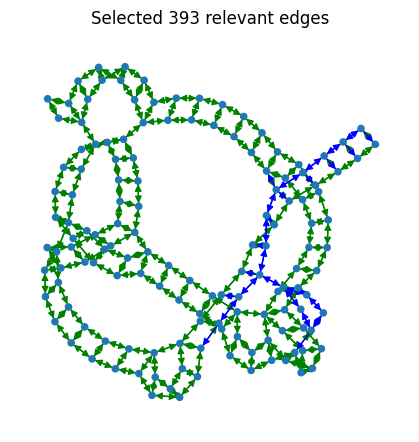

In [148]:
ratio = 0.9
idx = 4

G = graphs_nx[SPLIT][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[SPLIT][ratio][idx], spu_subgraphs_r[SPLIT][ratio][idx])

# G, _   = sample_edges(G, graphs[SPLIT][idx], None, spu_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=10, remove_undirected=False)

print(predict_sample([G], tested_pipeline, ratio=ratio).exp())
print(f"GT: {graphs[SPLIT][idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(4, 4), nodesize=20, with_labels=False);

Used  0
Used  1
Used  4
Used  4
Used  4
Used  5
Used  6
Used  8
Used  8
Used  10


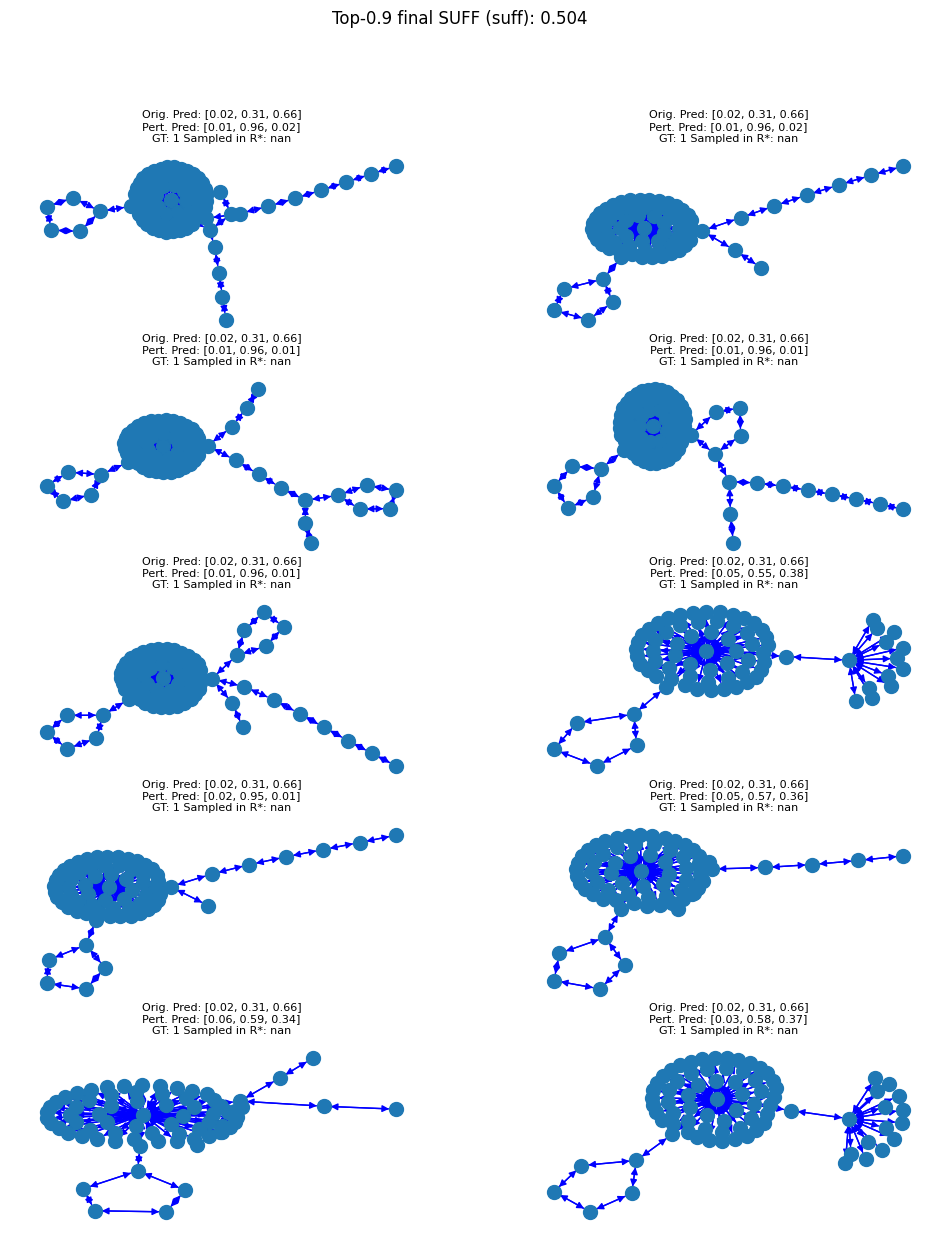

In [144]:
metric = "suff"
sample_method = "suff"

empty_idx = set()
sampled_G = []
num_samples = 10
orig_predictions = predict_sample([G], tested_pipeline, ratio=ratio).repeat_interleave(num_samples, dim=0)
for j in range(num_samples):
    config.random_seed = 304 + j
    reset_random_seed(config)
    
    G = graphs_nx[SPLIT][idx].copy()    

    if sample_method == "suff":
        G_filt = xai_utils.remove_from_graph(G, "spu", spu_subgraphs_r[SPLIT][ratio][idx])
        num_elem = xai_utils.mark_frontier(G, G_filt)
        if len(G_filt) == 0 or num_elem == 0:
            raise ValueError(f"{j} {num_elem}")
        G_union = None
        while G_union is None:
            G_union = tested_pipeline.get_intervened_graph(
                metric,
                "model_dependent",
                graphs_nx[SPLIT][j],
                empty_idx,
                causal_subgraphs_r[SPLIT][ratio][j],
                spu_subgraphs_r[SPLIT][ratio][j],
                G_filt,
                False,
                (idx, j, 0),
                feature_intervention=False,
                feature_bank=None
            )
            if G_union is None:
                j = j + 1
            else:
                print("Used ", j)
    else:
        G_union, _   = sample_edges(G, graphs[SPLIT][idx], None, spu_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=int((1-alpha)*avg_graph_size[SPLIT]), remove_undirected=False)
    
    sampled_G.append((G_union, np.nan))    
predictions = predict_sample([s[0] for s in sampled_G], tested_pipeline, ratio=ratio)


# Compute NEC
div = torch.nn.KLDivLoss(reduction="none", log_target=True)(orig_predictions, predictions).sum(-1)
aggr = torch.exp(-scatter_mean(div, torch.zeros(predictions.shape[0], dtype=int, device=predictions.device), dim=0)) 

predictions = torch.exp(predictions) # undo the log_softmax
orig_predictions = torch.exp(orig_predictions)
n_row = num_samples // 2
fig, axs = plt.subplots(n_row, 2, figsize=(12,14))
for j in range(num_samples):
    ax = axs[j // 2, j % 2]
    draw(config, sampled_G[j][0], name="", save=False, figsize=(3, 3), nodesize=100, with_labels=False, title=get_title_predition(orig_predictions, predictions, j, graphs[SPLIT][idx].y, sampled_G[j][1]), ax=ax);
plt.suptitle(f"Top-{ratio} final {metric.upper()} ({sample_method}): {round(aggr.item(), 3)}")
plt.show()

GT: tensor([1])
Selected 21 relevant edges over 34


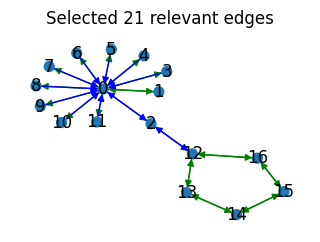

tensor([[0.0568, 0.8418, 0.1014]])
tensor([[0.0479, 0.8619, 0.0902]])
SUFF=3.414
Selected 20 relevant edges over 32


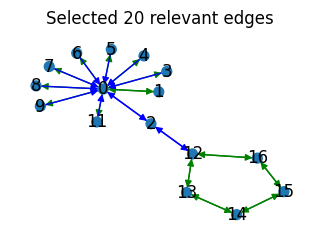

In [30]:
SPLIT = "val"
ratio = 0.6
idx = 0

G = graphs_nx[SPLIT][idx].copy()
xai_utils.mark_edges(G, causal_subgraphs_r[SPLIT][ratio][idx], spu_subgraphs_r[SPLIT][ratio][idx])
print(f"GT: {graphs[SPLIT][idx].y}")
pos = xai_utils.draw(config, G, name="", save=False, figsize=(3, 2), nodesize=50, with_labels=True);

original_prediction = predict_sample([G], tested_pipeline, ratio=ratio).exp()
print(original_prediction)

G_sampled, edges_in_gt = sample_edges(G, graphs[SPLIT][idx], 0.9, causal_subgraphs_r[SPLIT][ratio][idx], ratio=ratio, edge_remove=[(10,0)])
sampled_prediction = predict_sample([G_sampled], tested_pipeline, ratio=ratio)
print(sampled_prediction.exp())

div = torch.nn.KLDivLoss(reduction="none", log_target=True)(original_prediction, sampled_prediction).sum(-1)
aggr = torch.exp(-scatter_mean(div, torch.zeros(sampled_prediction.shape[0]).long(), dim=0)).mean().item()
print(f"SUFF={aggr:.3f}")

xai_utils.draw(config, G_sampled, name="", save=False, figsize=(3, 2), nodesize=50, with_labels=True, pos=pos);



### Create bank of possible interventions

In [9]:
interventional_bank = defaultdict(list)

for SPLIT in ["id_val", "test", "val"]:
    bank_idxs, _ = train_test_split(
        np.arange(len(graphs[SPLIT])),
        train_size=500,
        random_state=42,
        shuffle=True,
        stratify=None
    )

    for ratio in ratios:
        for bank_idx in bank_idxs:
            int_graph = graphs_nx[SPLIT][bank_idx].copy()
            int_graph_filt = xai_utils.remove_from_graph(int_graph, edge_index_to_remove=causal_subgraphs_r[SPLIT][ratio][bank_idx])
            nx.set_node_attributes(int_graph_filt, name="frontier", values=False) # check if needed

            if not (int_graph_filt is None or len(int_graph_filt.edges()) == 0 or len(int_graph_filt) == 0):
                interventional_bank[ratio].append(int_graph_filt)

### Does our SUFF correlated with how likely is to change the model's predictions?

In [10]:
metric = "suff"
alpha = 0.95
SPLIT = "test"

num_samples = 10
num_seeds = 2
suffs, change_of_pred, rfidm_div, rfidm, fidm_div, accs = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
suffs_all, fidm_div_all = defaultdict(list), defaultdict(list)
rfidm_div_bern, rfidm_bern = defaultdict(list), defaultdict(list)
preds, ori_preds, preds_suff, preds_suff_all = defaultdict(dict), defaultdict(dict), defaultdict(dict), defaultdict(dict)
empty_idx = set()
idxs, _ = train_test_split(
    np.arange(len(graphs[SPLIT])),
    train_size=200,
    random_state=42,
    shuffle=True,
    stratify=[graphs[SPLIT][i].y.item() for i in range(len(graphs[SPLIT]))]
)
for ratio in ratios:    
    for seed in range(num_seeds):        
        ori_graphs, sampled = [], []
        belonging, labels = [], torch.tensor([])
        labels_norep = torch.tensor([])
        for idx in idxs:
            G = graphs_nx[SPLIT][idx].copy()
            if len(G.edges()) == 0 or len(G.nodes()) == 0:
                continue

            labels_norep = torch.cat((labels_norep, graphs[SPLIT][idx].y), dim=0)
            for j in range(num_samples):
                config.random_seed = 304 * seed + j
                reset_random_seed(config)

                G_sampled, _   = sample_edges(G, graphs[SPLIT][idx], None, spu_subgraphs_r[SPLIT][ratio][idx], ratio=1, num_to_remove=int((1-alpha)*avg_graph_size[SPLIT]), remove_undirected=False)
                G_bernoulli, _ = sample_edges_rfid(G, graphs[SPLIT][idx], alpha, spu_subgraphs_r[SPLIT][ratio][idx])
                
                # SUFF over same split
                G2 = graphs_nx[SPLIT][idx].copy()
                G_filt = xai_utils.remove_from_graph(G2, spu_subgraphs_r[SPLIT][ratio][idx])
                num_elem = xai_utils.mark_frontier(G2, G_filt)
                if len(G_filt) == 0 or num_elem == 0:
                    raise ValueError(f"{j} {num_elem}")                
                G_union = None
                while G_union is None:
                    G_union = tested_pipeline.get_intervened_graph(
                        metric,
                        "model_dependent",
                        graphs_nx[SPLIT][j],
                        empty_idx,
                        causal_subgraphs_r[SPLIT][ratio][j],
                        spu_subgraphs_r[SPLIT][ratio][j],
                        G_filt,
                        False,
                        (idx, j, 0),
                        feature_intervention=False,
                        feature_bank=None
                    )
                    if G_union is None:
                        j = j + 1
                
                # SUFF over all split
                source = graphs_nx[SPLIT][idx].copy()
                source_filt = xai_utils.remove_from_graph(source, spu_subgraphs_r[SPLIT][ratio][idx])
                xai_utils.mark_frontier(source, source_filt)

                target = interventional_bank[ratio][randint(0, len(interventional_bank[ratio])-1)]
                G_union_all = xai_utils.random_attach_no_target_frontier(source_filt, target)
                
                sampled.append((G_sampled, G_bernoulli, G_union, G_union_all))
                ori_graphs.append((G, np.nan))
                belonging.append(idx)
                labels = torch.cat((labels, graphs[SPLIT][idx].y), dim=0)
            
        pred_all = predict_sample([s[0] for s in ori_graphs] + [s[0] for s in sampled] + [s[1] for s in sampled] + [s[2] for s in sampled] + [s[3] for s in sampled], tested_pipeline, ratio=ratio)
        ori_pred = pred_all[:len(ori_graphs)]
        pred = pred_all[len(ori_graphs):len(ori_graphs) + len(sampled)]
        pred_bern = pred_all[len(ori_graphs) + len(sampled):len(ori_graphs) + 2*len(sampled)]
        pred_suff = pred_all[len(ori_graphs) + 2*len(sampled):len(ori_graphs) + 3*len(sampled)]
        pred_suff_all = pred_all[len(ori_graphs) + 3*len(sampled):]

        ori_preds[ratio][seed] = ori_pred
        preds[ratio][seed] = pred
        preds_suff[ratio][seed] = pred_suff
        preds_suff_all[ratio][seed] = pred_suff_all
        
        belonging = normalize_belonging(belonging).to(pred.device)

        # SUFF over same split
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_suff).sum(-1)
        aggr = torch.exp(-scatter_mean(div, belonging, dim=0))
        suffs[ratio].append(aggr.mean().item())
        fidm_div[ratio].append(torch.exp(-torch.abs(ori_pred.exp() - pred_suff.exp()).sum(-1).mean()))

        # SUFF over all split
        div = torch.nn.KLDivLoss(reduction="none", log_target=True)(ori_pred, pred_suff_all).sum(-1)
        aggr = torch.exp(-scatter_mean(div, belonging, dim=0))
        suffs_all[ratio].append(aggr.mean().item())
        fidm_div_all[ratio].append(torch.exp(-torch.abs(ori_pred.exp() - pred_suff_all.exp()).sum(-1).mean()))

        rfidm_bern[ratio].append(torch.exp(-torch.abs(ori_pred.exp().gather(1, labels.view(-1).long().unsqueeze(1)) - pred_bern.exp().gather(1, labels.view(-1).long().unsqueeze(1))).mean()))
        rfidm_div_bern[ratio].append(torch.exp(-torch.abs(ori_pred.exp() - pred_bern.exp()).sum(-1).mean()))
        rfidm[ratio].append(torch.exp(-torch.abs(ori_pred.exp().gather(1, labels.view(-1).long().unsqueeze(1)) - pred.exp().gather(1, labels.view(-1).long().unsqueeze(1))).mean()))
        rfidm_div[ratio].append(torch.exp(-torch.abs(ori_pred.exp() - pred.exp()).sum(-1).mean()))

        change_of_pred[ratio].append(sum(ori_pred.argmax(-1) != pred.argmax(-1)) / pred.shape[0])        
        accs[ratio].append(sum(labels.view(-1) == ori_pred.argmax(-1)) / ori_pred.shape[0])

In [1]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

color_metrics = {
    "SUFF KL": "blue",
    "SUFF ALL KL": "black",
    "SUFF L1": "green",
    "SUFF ALL L1": "brown",
    "RFID-": "orange",
    "RFID- div": "red",
    "FID- deconf.": "pink",
    "FID- div deconf.": "violet"
}
for r in ratios:
    # axs[0,0].scatter(r, np.mean(rfidm_bern[r]), label=f"RFID-" if r == 0.3 else None, c=color_metrics["RFID-"])
    axs[0,0].scatter(r, np.mean(rfidm_div_bern[r]), label=f"RFID- div" if r == 0.3 else None, c=color_metrics["RFID- div"])
    # axs[0,0].scatter(r, np.mean(rfidm[r]), label=f"FID- deconf." if r == 0.3 else None, c=color_metrics["FID- deconf."])
    axs[0,0].scatter(r, np.mean(rfidm_div[r]), label=f"FID- div deconf." if r == 0.3 else None, c=color_metrics["FID- div deconf."])
    axs[0,0].scatter(r, np.mean(suffs[r]), label=f"SUFF KL" if r == 0.3 else None, c=color_metrics["SUFF KL"])
    axs[0,0].scatter(r, np.mean(fidm_div[r]), label=f"SUFF L1" if r == 0.3 else None, c=color_metrics["SUFF L1"])
    axs[0,0].scatter(r, np.mean(suffs_all[r]), label=f"SUFF ALL KL" if r == 0.3 else None, c=color_metrics["SUFF ALL KL"])
    axs[0,0].scatter(r, np.mean(fidm_div_all[r]), label=f"SUFF ALL L1" if r == 0.3 else None, c=color_metrics["SUFF ALL L1"])
axs[0,0].legend()
axs[0,0].grid(visible=True, alpha=0.5)
axs[0,0].set_title(f"SUFF & RFID")
axs[0,0].set_xlabel("ratios")
axs[0,0].set_ylabel("metrics values")
axs[0,0].set_ylim((0., 1.1))


ratio_change_pred = [[change_of_pred[r][i]] for r in ratios for i in range(num_seeds)]
rfid_plot = [rfidm_bern[r][i] for r in ratios for i in range(num_seeds)]
rfid_div_plot = [rfidm_div_bern[r][i] for r in ratios for i in range(num_seeds)]
suffkl_plot = np.array([suffs_all[r][i] for r in ratios for i in range(num_seeds)])
suffl1_plot = np.array([fidm_div_all[r][i].item() for r in ratios for i in range(num_seeds)])
fidm_div_plot = np.array([rfidm_div[r][i].item() for r in ratios for i in range(num_seeds)])

pcc_rfid = r_regression(ratio_change_pred, rfid_plot)[0]
pcc_rfid_div = r_regression(ratio_change_pred, rfid_div_plot)[0]
pcc_suffkl = r_regression(ratio_change_pred, suffkl_plot)[0]
pcc_suffl1 = r_regression(ratio_change_pred, suffl1_plot)[0]
pcc_fidm_suffkl = r_regression(fidm_div_plot.reshape(-1,1), suffkl_plot)[0]
pcc_fidm_suffl1 = r_regression(fidm_div_plot.reshape(-1,1), suffl1_plot)[0]

# axs[0,1].scatter(ratio_change_pred, rfid_plot,     c=color_metrics["RFID-"],     label=f"RFID- {pcc_rfid:.2f}")
axs[0,1].scatter(ratio_change_pred, rfid_div_plot, c=color_metrics["RFID- div"], label=f"RFID- div {pcc_rfid_div:.2f}")
axs[0,1].scatter(ratio_change_pred, suffkl_plot,   c=color_metrics["SUFF KL"],   label=f"SUFF KL {pcc_suffkl:.2f}")
axs[0,1].scatter(ratio_change_pred, suffl1_plot,   c=color_metrics["SUFF L1"],   label=f"SUFF L1 {pcc_suffl1:.2f}")
axs[0,1].scatter(suffkl_plot, fidm_div_plot ,      c="violet",                   label=f"SUFF ALL KL vs FID- deconf div {pcc_fidm_suffkl:.2f}")
axs[0,1].scatter(suffl1_plot, fidm_div_plot ,      c="pink",                     label=f"SUFF ALL L1 vs FID- deconf div {pcc_fidm_suffl1:.2f}")
axs[0,1].legend()
axs[0,1].grid(visible=True, alpha=0.5)
axs[0,1].set_title("PCC of metrics with ratio_change_pred")
axs[0,1].set_xlabel("ratios")
axs[0,1].set_ylabel("metrics values")
axs[0,1].set_ylim((0., 1.3))

for r in ratios:
    axs[1,0].scatter(r, np.mean(change_of_pred[r]), label=r, c="blue", alpha=0.7)
    # axs[1,0].scatter(r, np.mean(change_of_pred[r]) + np.std(change_of_pred[r]), c="r", marker="v")
axs[1,0].grid(visible=True, alpha=0.5)
axs[1,0].set_title("Ratio of prediction changes with deconf. sampling")
axs[1,0].set_xlabel("ratios")
axs[1,0].set_ylabel("Percentage of times")
axs[1,0].set_ylim((0., 1.))


for r in ratios:
    axs[1,1].scatter(r, np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)]), marker="D", c="orange", label="Acc on deconf. sampling" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean([accuracy_score(labels, preds_suff[r][s].argmax(-1)) for s in range(num_seeds)]), marker="D", c="red", label="Acc under glueing" if r == 0.3 else None)
    axs[1,1].scatter(r, abs(np.mean(accs[r]) - np.mean([accuracy_score(labels, preds_suff[r][s].argmax(-1)) for s in range(num_seeds)])), c="red", marker="s", alpha=0.5, label="Diff. with glueing" if r == 0.3 else None)
    axs[1,1].scatter(r, abs(np.mean(accs[r]) - np.mean([accuracy_score(labels, preds[r][s].argmax(-1)) for s in range(num_seeds)])), c="orange", marker="s", alpha=0.5, label="Diff. with deconf sampl" if r == 0.3 else None)
    axs[1,1].scatter(r, np.mean(accs[r]), c="blue", label="Model acc" if r == 0.3 else None)
axs[1,1].legend()
axs[1,1].grid(visible=True, alpha=0.5)
axs[1,1].set_title("Difference in Acc between R and R'")
axs[1,1].set_xlabel("ratios")
axs[1,1].set_ylabel("Model Acc - Acc Intervened Graphs")
axs[1,1].set_ylim((-0.3, 1.))
plt.suptitle(f"{MODEL} - {DATASET} - {SPLIT}")
plt.show();

NameError: name 'plt' is not defined